GPUs are used!
FVMF RELOADED
GPUs are used!
FVMF RELOADED
GPUs are used!
0
Random Init Utilized


/opt/uio/modules/rhel8/easybuild/software/Miniconda3/lmsunde/envs/BNN2/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1
loss: tensor(350.0442, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(49.1581, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(297.2805, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(16.6147, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(276.6905, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(13.7142, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(256.4194, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(12.5797, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(239.7066, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(13.1582, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(219.7606, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(12.9421, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(201.7312, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihoo

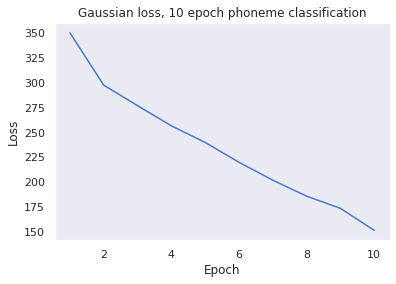

In [1]:
#matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os

import importlib
import FVMF
importlib.reload(FVMF)
import test_ensemble
importlib.reload(test_ensemble)

prefix = "_phoneme_bg_"
# define the summary writer
writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")


# select the device
DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)

if (torch.cuda.is_available()):
    print("GPUs are used!")
else:
    print("CPUs are used!")

# define the parameters
BATCH_SIZE = 100
TEST_BATCH_SIZE = 100
COND_OPT = False
CLASSES = 5
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50

#prepare the data
data = pd.read_csv('http://www.uio.no/studier/emner/matnat/math/STK2100/data/phoneme.data')
data = data.drop(columns=["row.names"])
data = pd.concat([data,data.g.astype("category").cat.codes.astype(int)],sort=False, axis=1) #get_dummies(data['g'], prefix='phoneme')],sort=False, axis=1)
data = data.drop(columns=["g","speaker"])
data = data.values

np.random.seed(40590)

tr_ids = np.random.choice(4509, 3500, replace = False)
te_ids = np.setdiff1d(np.arange(4509),tr_ids)[0:1000]

dtrain = data[tr_ids,:]

data_mean = dtrain.mean(axis=0)[0:256]
data_std = dtrain.std(axis=0)[0:256]

data[:,0:256] = (data[:,0:256]  - data_mean)/data_std

dtrain = data[tr_ids,:]
dtest = data[te_ids,:]


# set prior parameters
PI = 1
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])


#The net does not like to get larger at a given layer??
l1shape=(256, 10)
l2shape=(10, 10)
l3shape=(10, 10)
l4shape=(10, 5)
layershapes = [l1shape, l2shape, l3shape, l4shape]

epochs = 10
trtimes  = []
# make inference on 10 networks
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net = FVMF.BayesianNetwork(layershapes=layershapes,BN='notbatchnorm',VD='Gaussian',
                               dtrain=dtrain,dtest=dtest,BATCH_SIZE = 100,classification = 'classification').to(DEVICE)
    #net = VMF.BayesianNetwork(l1=l1shape, l2=l2shape, l3=l3shape,l4=l4shape,BN='notbatchnorm').to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=0.007)
    for epoch in range(epochs):

        train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        #print(net.l1.weight_mu.mean())

    res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")


x = []
for i in range(epochs):
    x.append(i+1)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gaussian loss, 10 epoch phoneme classification')
plt.plot(x,trtimes)
plt.savefig('Plots/Gaussian_loss_10_epoch_phoneme_classification.png')
plt.show()

GPUs are used!
FVMF RELOADED
0
Random Init Utilized


/opt/uio/modules/rhel8/easybuild/software/Miniconda3/lmsunde/envs/BNN2/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


1
loss: tensor(208.9301, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(53.8483, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.3046, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(15.0372, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(198.2865, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(17.0525, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.9646, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(17.5934, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(169.0435, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(19.6990, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(5.8137, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(18.7951, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(159.2988, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(15.4887, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(6.060

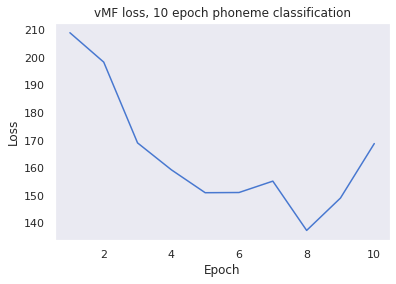

In [2]:
#import importlib
#import os
import FVMF
importlib.reload(FVMF)

#import VMF

#import importlib
#importlib.reload(VMF)

prefix = "_phoneme_bg_"
# define the summary writer
writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")


# select the device
DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)

# define the parameters
BATCH_SIZE = 100
TEST_BATCH_SIZE = 100
batch_size = 100
COND_OPT = False
CLASSES = 5
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50

#prepare the data
data = pd.read_csv('http://www.uio.no/studier/emner/matnat/math/STK2100/data/phoneme.data')
data = data.drop(columns=["row.names"])
data = pd.concat([data,data.g.astype("category").cat.codes.astype(int)],sort=False, axis=1) #get_dummies(data['g'], prefix='phoneme')],sort=False, axis=1)
data = data.drop(columns=["g","speaker"])
data = data.values

np.random.seed(40590)

tr_ids = np.random.choice(4509, 3500, replace = False)
te_ids = np.setdiff1d(np.arange(4509),tr_ids)[0:1000]

dtrain = data[tr_ids,:]

data_mean = dtrain.mean(axis=0)[0:256]
data_std = dtrain.std(axis=0)[0:256]

data[:,0:256] = (data[:,0:256]  - data_mean)/data_std

dtrain = data[tr_ids,:]
dtest = data[te_ids,:]

# set prior parameters
PI = 1
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])

epochs = 10
trtimes  = []
#w_mu = [w_mu1, w_mu2, w_mu3, w_mu4]
#b_mu = [b_mu1, b_mu2, b_mu3, b_mu4]

#w_mu_nodewise = [w_mu1_nodewise,w_mu2_nodewise,w_mu3_nodewise,w_mu4_nodewise]
#b_mu_nodewise = [b_mu1_nodewise,b_mu2_nodewise,b_mu3_nodewise,b_mu4_nodewise]
# make inference on 10 networks

for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 1, normalize = 'No',classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net2.weight_mu[1].max())
        print('norm:',torch.norm(net2.weight_mu[1]))

    res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
plt.title('vMF loss, 10 epoch phoneme classification')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/vMF_loss_10_epoch_phoneme_classification.png')
plt.show()

0
Random Init Utilized
1
loss: tensor(412.0250, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(100.9529, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(338.8826, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(37.1010, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(317.0960, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(22.0465, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(303.8429, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(17.2404, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(295.4734, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(15.6428, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(285.1866, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(14.7633, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(275.3525, device='cuda:1', grad_fn=<AddBackward0>

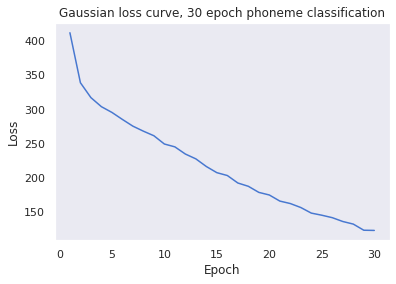

In [3]:
epochs = 30
trtimes  = []
# make inference on 10 networks
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net = FVMF.BayesianNetwork(layershapes=layershapes,BN='notbatchnorm',VD='Gaussian',
                               dtrain=dtrain,dtest=dtest,BATCH_SIZE = 100,classification = 'classification').to(DEVICE)
    #net = VMF.BayesianNetwork(l1=l1shape, l2=l2shape, l3=l3shape,l4=l4shape,BN='notbatchnorm').to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=0.003)
    for epoch in range(epochs):

        train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        #print(net.l1.weight_mu.mean())

    res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))
x = []
for i in range(epochs):
    x.append(i+1)
plt.title('Gaussian loss curve, 30 epoch phoneme classification')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/Gaussian_loss_30_epoch_phoneme_classification.png')
plt.show()

0
Random Init Utilized
1
loss: tensor(236.7406, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(79.1357, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(2.3362, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(11.8259, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(209.9905, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(45.3556, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(2.8906, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(11.7916, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(197.3064, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(39.7432, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(3.7135, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(11.7596, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(198.7411, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(40.7713, device='cuda:1', grad_fn=<NllLossBackwa

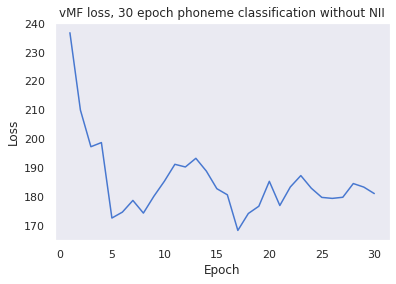

Component 0 Accuracy: 926.0/1000
Component 1 Accuracy: 924.0/1000
Component 2 Accuracy: 922.0/1000
Component 3 Accuracy: 925.0/1000
Component 4 Accuracy: 930.0/1000
Component 5 Accuracy: 918.0/1000
Component 6 Accuracy: 924.0/1000
Component 7 Accuracy: 928.0/1000
Component 8 Accuracy: 921.0/1000
Component 9 Accuracy: 925.0/1000
Posterior Mean Accuracy: 931.0/1000
Ensemble Accuracy: 929/1000


In [4]:
trtimes = []
epochs = 30
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net22 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 1, normalize = 'No',classification = 'classification')
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net22.parameters(), lr=0.035)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net22, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net22.weight_mu[1].max())
        print('norm:',torch.norm(net22.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
plt.title('vMF loss, 30 epoch phoneme classification without NII')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/vMF_loss_30_epoch_phoneme_classification_without_NII.png')
plt.show()
res = test_ensemble.test_ensemble(net22,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

0
Random Init Utilized
1
loss: tensor(208.9301, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(53.8483, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.3046, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(15.0372, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(198.2865, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(17.0525, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.9646, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(17.5934, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(169.0435, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(19.6990, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(5.8137, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(18.7951, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(159.2988, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(15.4887, device='cuda:1', grad_fn=<NllLossBackwa

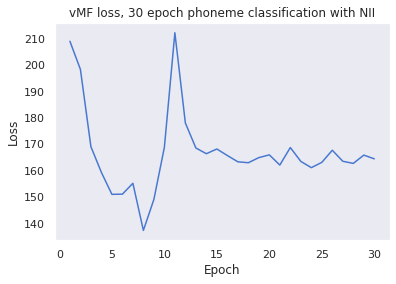

Component 0 Accuracy: 918.0/1000
Component 1 Accuracy: 911.0/1000
Component 2 Accuracy: 921.0/1000
Component 3 Accuracy: 924.0/1000
Component 4 Accuracy: 926.0/1000
Component 5 Accuracy: 917.0/1000
Component 6 Accuracy: 913.0/1000
Component 7 Accuracy: 919.0/1000
Component 8 Accuracy: 921.0/1000
Component 9 Accuracy: 913.0/1000
Posterior Mean Accuracy: 926.0/1000
Ensemble Accuracy: 931/1000


In [5]:
trtimes = []
epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 1, normalize = 'No',classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net2.weight_mu[1].max())
        print('norm:',torch.norm(net2.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
    
w_mu = []
for i in range(len(net2.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net2.weight_mu[i]/torch.norm(net2.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net2.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net2.bias_mu[i]/torch.norm(net2.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net2.bias_rho)):
    b_rho.append(net2.bias_rho[i])

w_rho= []
for i in range(len(net2.weight_rho)):
    w_rho.append(net2.weight_rho[i])
epochs = 20
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2_2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho,
                                Temper = 1, normalize = 'No',classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2_2.parameters(), lr=0.04)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2_2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net2_2.weight_mu[1].max())
        print('norm:',torch.norm(net2_2.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

#w_mu = []
#for i in range(len(net2_2.weight_mu)):
#    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
#    w_mu.append(net2_2.weight_mu[i]/torch.norm(net2_2.weight_mu[i]))
#    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
#    
#b_mu = []
#for i in range(len(net2_2.bias_mu)):
#    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
#    b_mu.append(net2_2.bias_mu[i]/torch.norm(net2_2.bias_mu[i]))
#    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
#    
#b_rho= []
#for i in range(len(net2_2.bias_rho)):
#    b_rho.append(net2_2.bias_rho[i])
#
#w_rho= []
#for i in range(len(net2_2.weight_rho)):
#    w_rho.append(net2_2.weight_rho[i])
#    
#for i in range(0, 1):
#    print(i)
#    torch.manual_seed(i)
#    net2_2_2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
#                                #w_mu = None, b_mu = None,
#                                #w_mu = w_mu_nodewise, b_mu = b_mu,
#                                layershapes = layershapes,
#                                dtrain=dtrain, dtest=dtest,
#                                VD='vmf',
#                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
#                                w_kappa= w_rho,
#                                Temper = 1, normalize = 'No',classification = 'classification')
#    
#    #for j,p in enumerate(net2.l1.parameters()):    
#    #p.requires_grad_(False)
#    
#    #for j,p in enumerate(net2.l2.parameters()):
#    #p.requires_grad_(False)
#    
#    optimizer = optim.Adam(net2_2_2.parameters(), lr=0.05)
#    
#    
#    for epoch in range(epochs):
#
#        train = FVMF.train(net2_2_2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
#        trtimes.append(train[1].detach().cpu().numpy())
#        
#        print('max:',net2_2_2.weight_mu[1].max())
#        print('norm:',torch.norm(net2_2_2.weight_mu[1]))
#
#    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))
#
#    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
plt.title('vMF loss, 30 epoch phoneme classification with NII')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/vMF_loss_30_epoch_phoneme_classification_with_NII.png')
plt.show()
res = test_ensemble.test_ensemble(net2_2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

0
Random Init Utilized
1
loss: tensor(412.0250, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(100.9529, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(338.8826, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(37.1010, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(317.0960, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(22.0465, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(303.8429, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(17.2404, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(295.4734, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(15.6428, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(285.1866, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(14.7633, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(275.3525, device='cuda:1', grad_fn=<AddBackward0>

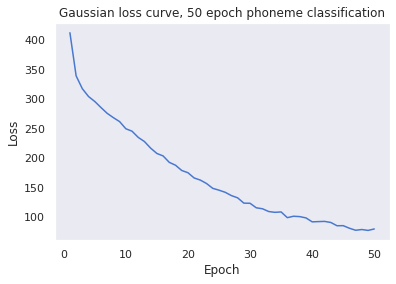

In [6]:
epochs = 50
trtimes  = []
# make inference on 10 networks
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net = FVMF.BayesianNetwork(layershapes=layershapes,BN='notbatchnorm',VD='Gaussian',
                               dtrain=dtrain,dtest=dtest,BATCH_SIZE = 100,classification = 'classification').to(DEVICE)
    #net = VMF.BayesianNetwork(l1=l1shape, l2=l2shape, l3=l3shape,l4=l4shape,BN='notbatchnorm').to(DEVICE)
    optimizer = optim.Adam(net.parameters(), lr=0.003)
    for epoch in range(epochs):

        train = FVMF.train(net, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        #print(net.l1.weight_mu.mean())

    res = test_ensemble.test_ensemble(net,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))
x = []
for i in range(epochs):
    x.append(i+1)
plt.title('Gaussian loss curve, 50 epoch phoneme classification')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/Gaussian_loss_50_epoch_phoneme_classification.png')
plt.show()

0
Random Init Utilized
1
loss: tensor(236.7406, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(79.1357, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(2.3362, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(11.8259, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(209.9905, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(45.3556, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(2.8906, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(11.7916, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(197.3064, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(39.7432, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(3.7135, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(11.7596, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(198.7411, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(40.7713, device='cuda:1', grad_fn=<NllLossBackwa

31
loss: tensor(184.0321, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(12.4702, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.6232, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(13.7231, device='cuda:1', grad_fn=<NormBackward1>)
32
loss: tensor(183.6259, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(10.2977, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.6610, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(13.8768, device='cuda:1', grad_fn=<NormBackward1>)
33
loss: tensor(175.4701, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(10.3554, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.6875, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(14.0014, device='cuda:1', grad_fn=<NormBackward1>)
34
loss: tensor(179.4096, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(12.1324, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4

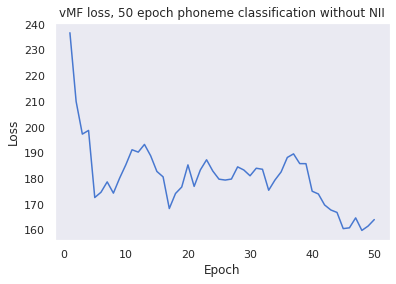

Component 0 Accuracy: 918.0/1000
Component 1 Accuracy: 913.0/1000
Component 2 Accuracy: 911.0/1000
Component 3 Accuracy: 915.0/1000
Component 4 Accuracy: 914.0/1000
Component 5 Accuracy: 919.0/1000
Component 6 Accuracy: 920.0/1000
Component 7 Accuracy: 916.0/1000
Component 8 Accuracy: 924.0/1000
Component 9 Accuracy: 911.0/1000
Posterior Mean Accuracy: 926.0/1000
Ensemble Accuracy: 925/1000


In [7]:
trtimes = []
epochs = 50
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net22 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 1, normalize = 'No',classification = 'classification')
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net22.parameters(), lr=0.035)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net22, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net22.weight_mu[1].max())
        print('norm:',torch.norm(net22.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
plt.title('vMF loss, 50 epoch phoneme classification without NII')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/vMF_loss_50_epoch_phoneme_classification_without_NII.png')
plt.show()
res = test_ensemble.test_ensemble(net22,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

0
Random Init Utilized
1
loss: tensor(208.9301, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(53.8483, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.3046, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(15.0372, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(198.2865, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(17.0525, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(4.9646, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(17.5934, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(169.0435, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(19.6990, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(5.8137, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(18.7951, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(159.2988, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(15.4887, device='cuda:1', grad_fn=<NllLossBackwa

1
loss: tensor(232.0099, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(80.3193, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.8775, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(2.8484, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(219.6482, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(69.8650, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.9845, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(3.1734, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(186.2986, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(35.4834, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(1.0476, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(3.3063, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(171.6591, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(21.4709, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(1.1618, 

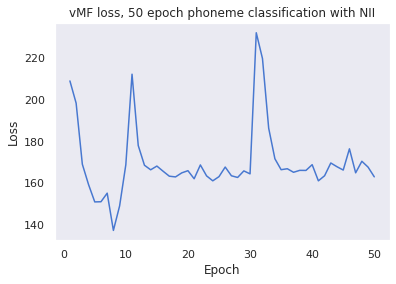

Component 0 Accuracy: 916.0/1000
Component 1 Accuracy: 919.0/1000
Component 2 Accuracy: 911.0/1000
Component 3 Accuracy: 928.0/1000
Component 4 Accuracy: 919.0/1000
Component 5 Accuracy: 908.0/1000
Component 6 Accuracy: 910.0/1000
Component 7 Accuracy: 921.0/1000
Component 8 Accuracy: 912.0/1000
Component 9 Accuracy: 898.0/1000
Posterior Mean Accuracy: 929.0/1000
Ensemble Accuracy: 930/1000


In [8]:
trtimes = []
epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.5,6.6),
                                Temper = 1, normalize = 'No',classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net2.weight_mu[1].max())
        print('norm:',torch.norm(net2.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
    
w_mu = []
for i in range(len(net2.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net2.weight_mu[i]/torch.norm(net2.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net2.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net2.bias_mu[i]/torch.norm(net2.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net2.bias_rho)):
    b_rho.append(net2.bias_rho[i])

w_rho= []
for i in range(len(net2.weight_rho)):
    w_rho.append(net2.weight_rho[i])
epochs = 20
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2_2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho,
                                Temper = 1, normalize = 'No',classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2_2.parameters(), lr=0.04)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2_2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net2_2.weight_mu[1].max())
        print('norm:',torch.norm(net2_2.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

w_mu = []
for i in range(len(net2_2.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net2_2.weight_mu[i]/torch.norm(net2_2.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net2_2.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net2_2.bias_mu[i]/torch.norm(net2_2.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net2_2.bias_rho)):
    b_rho.append(net2_2.bias_rho[i])

w_rho= []
for i in range(len(net2_2.weight_rho)):
    w_rho.append(net2_2.weight_rho[i])
    
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net2_2_2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho,
                                Temper = 1, normalize = 'No',classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #p.requires_grad_(False)
    
    #for j,p in enumerate(net2.l2.parameters()):
    #p.requires_grad_(False)
    
    optimizer = optim.Adam(net2_2_2.parameters(), lr=0.04)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net2_2_2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = (0,256,256,257))
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net2_2_2.weight_mu[1].max())
        print('norm:',torch.norm(net2_2_2.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
plt.title('vMF loss, 50 epoch phoneme classification with NII')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x,trtimes)
plt.savefig('Plots/vMF_loss_50_epoch_phoneme_classification_with_NII.png')
plt.show()
res = test_ensemble.test_ensemble(net2_2_2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = (0,256,256,257))

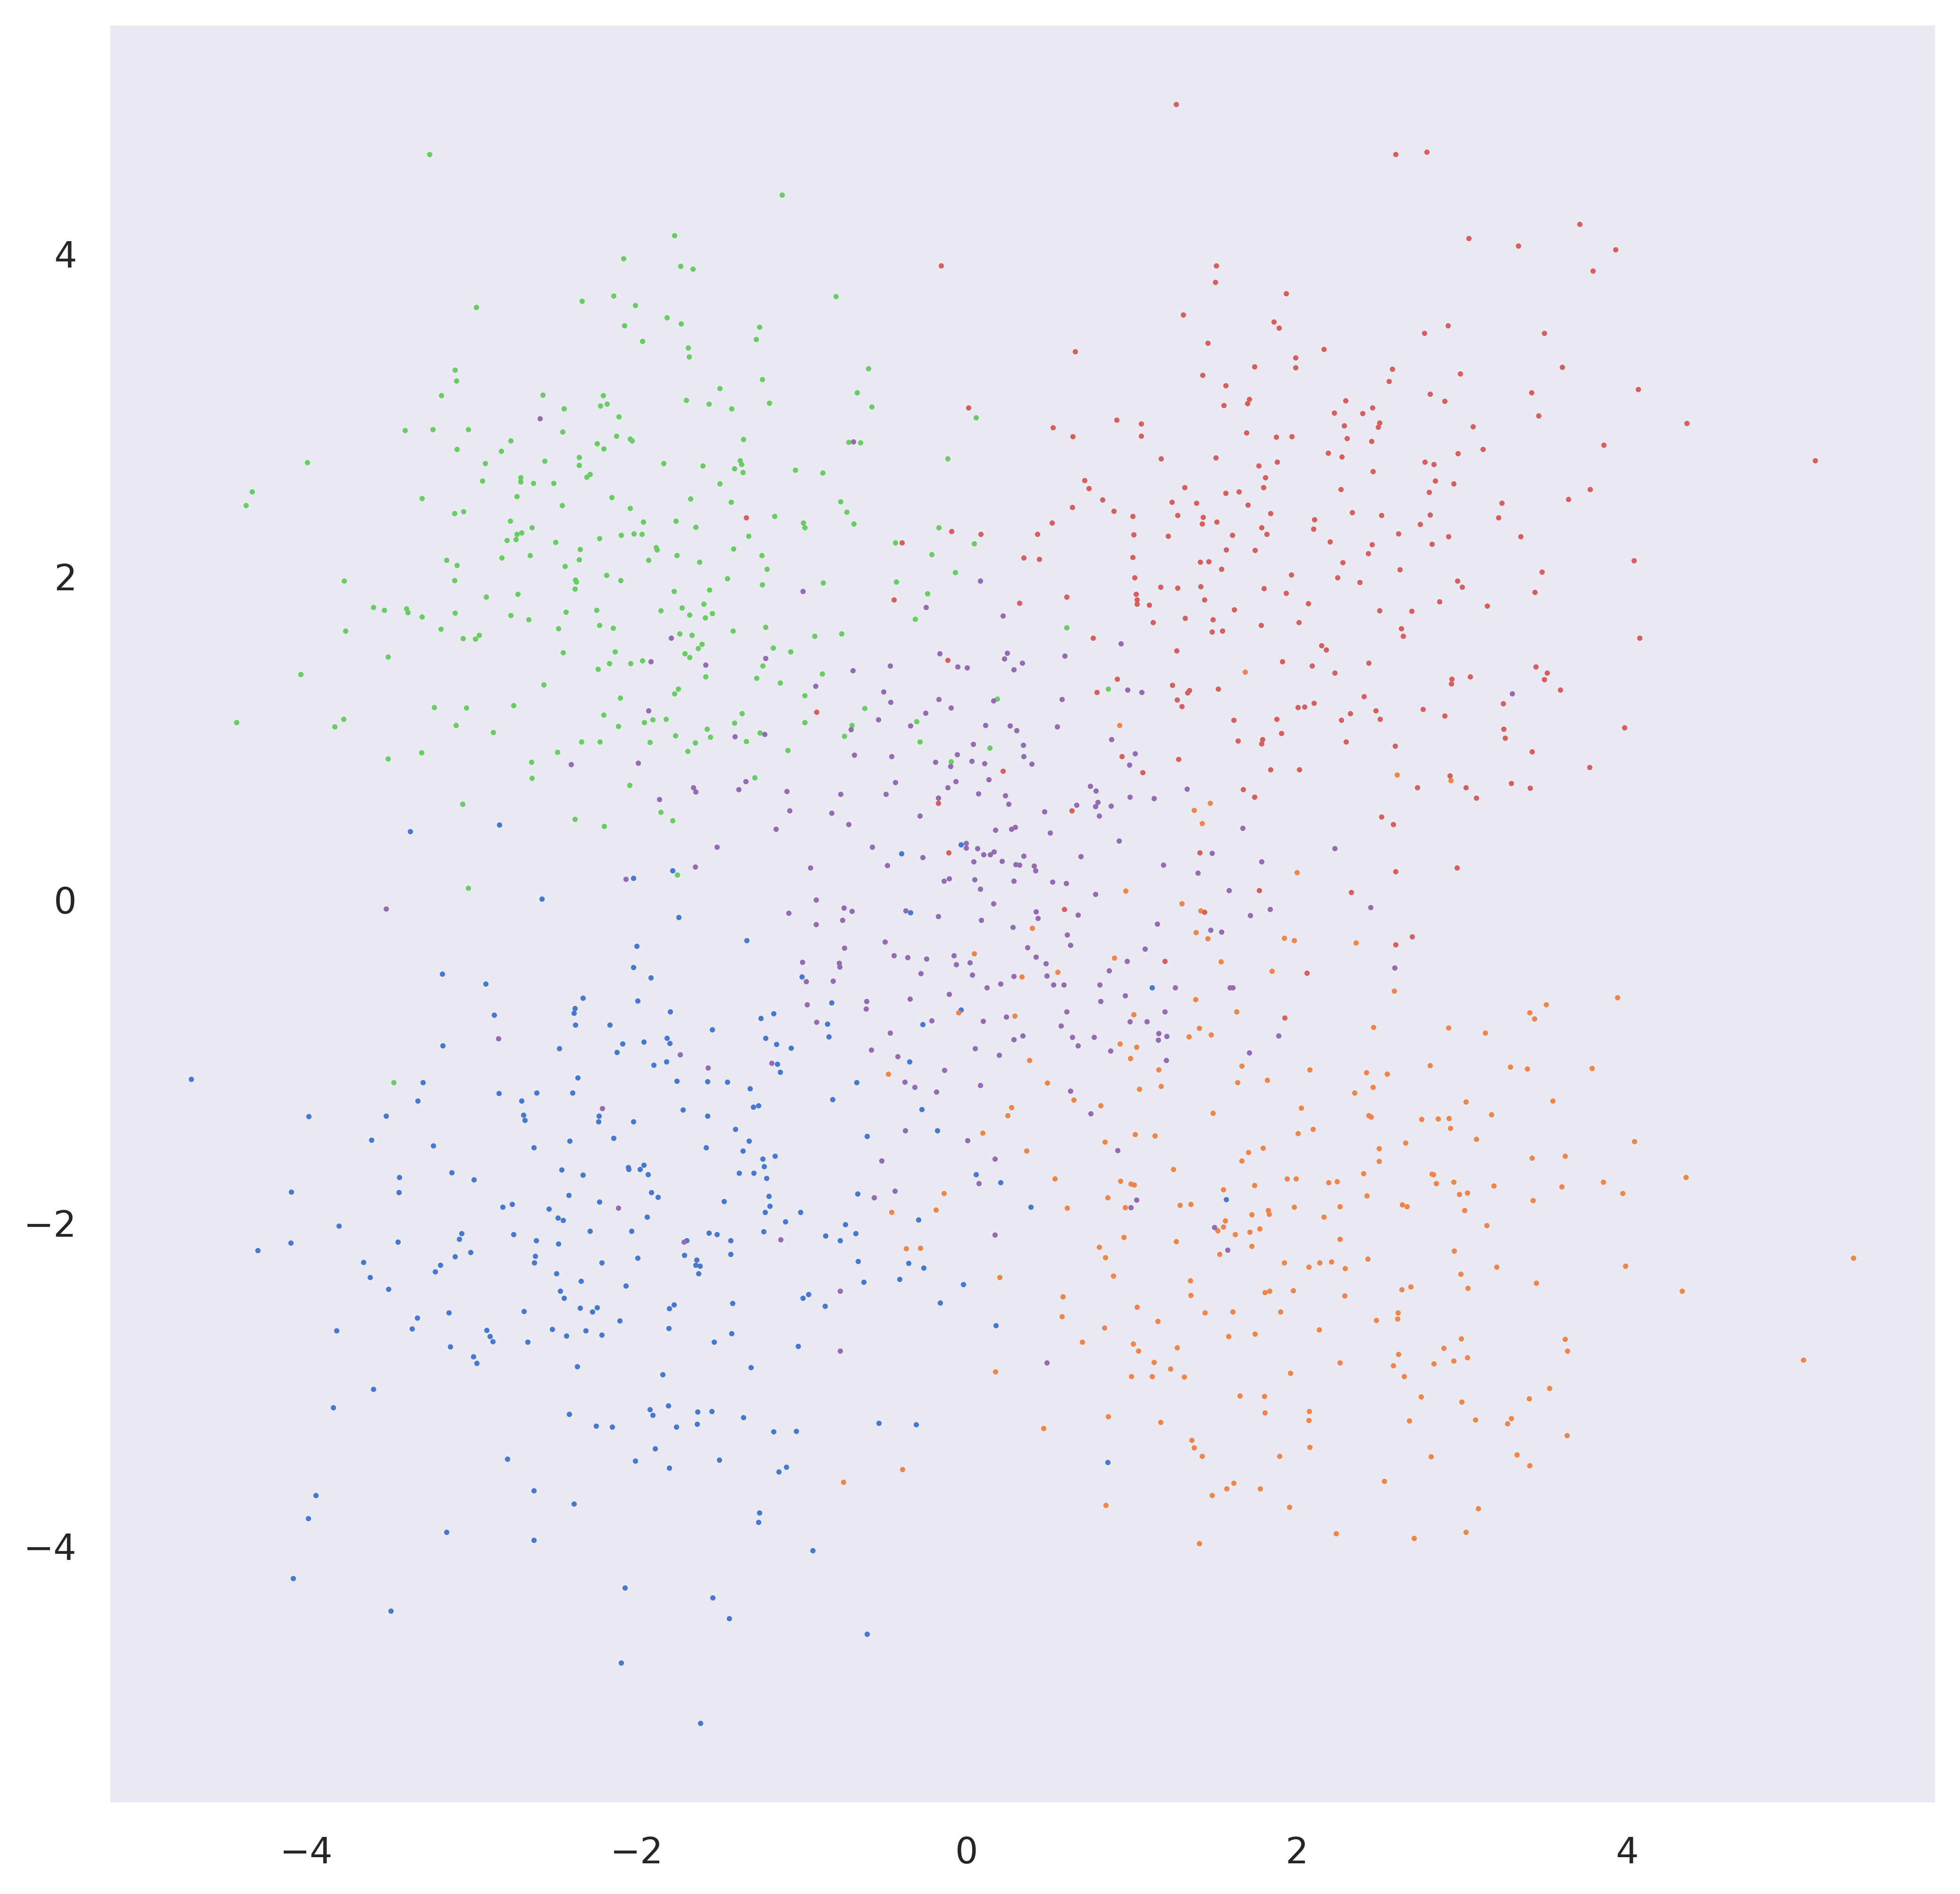

GPUs are used!
FVMF RELOADED
0
Random Init Utilized
1
loss: tensor(198.5192, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(159.4439, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.5144, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(1.0287, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(165.5533, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(131.4408, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.7416, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(1.7115, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(154.6759, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(123.5268, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.8082, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(1.9658, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(144.0914, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(116.6326, device='c

Component 0 Accuracy: 848.0/1000
Component 1 Accuracy: 849.0/1000
Component 2 Accuracy: 839.0/1000
Component 3 Accuracy: 843.0/1000
Component 4 Accuracy: 845.0/1000
Component 5 Accuracy: 856.0/1000
Component 6 Accuracy: 838.0/1000
Component 7 Accuracy: 839.0/1000
Component 8 Accuracy: 854.0/1000
Component 9 Accuracy: 843.0/1000
Posterior Mean Accuracy: 861.0/1000
Ensemble Accuracy: 862/1000
0
Random Init Utilized
1
loss: tensor(145.0210, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(133.9513, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(140.4265, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(129.1998, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(135.0922, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(123.8777, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(130.9398, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(119.1864, device='cuda:1',

10
loss: tensor(57.8745, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(42.9390, device='cuda:1', grad_fn=<NllLossBackward0>)
0
1
loss: tensor(62.5406, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(48.2264, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(61.6156, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(46.9058, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(55.8229, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(42.8347, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(60.4272, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(46.1622, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(58.8962, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(44.3255, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(57.0864, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: t

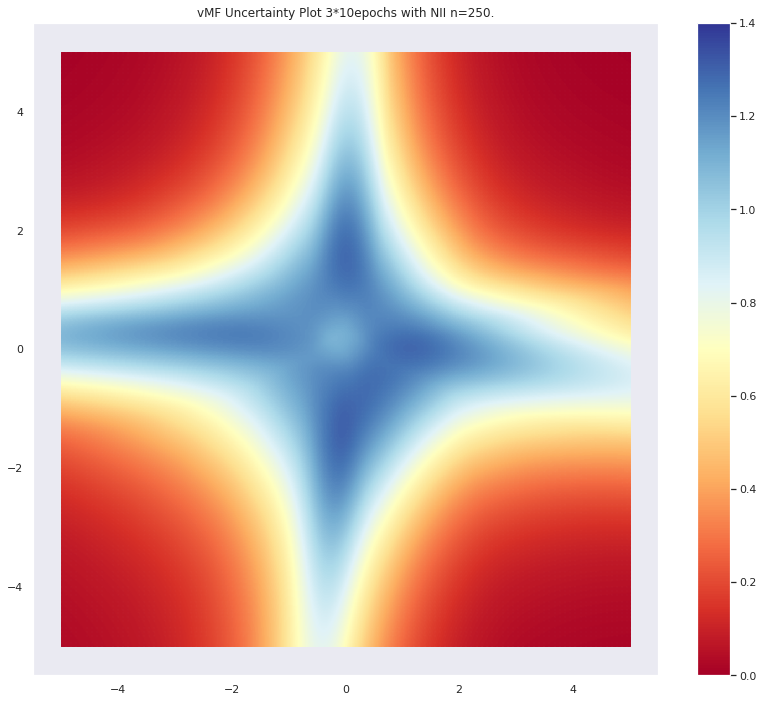

tensor(1.3692, grad_fn=<MaxBackward1>) tensor(0.0055, grad_fn=<MinBackward1>)


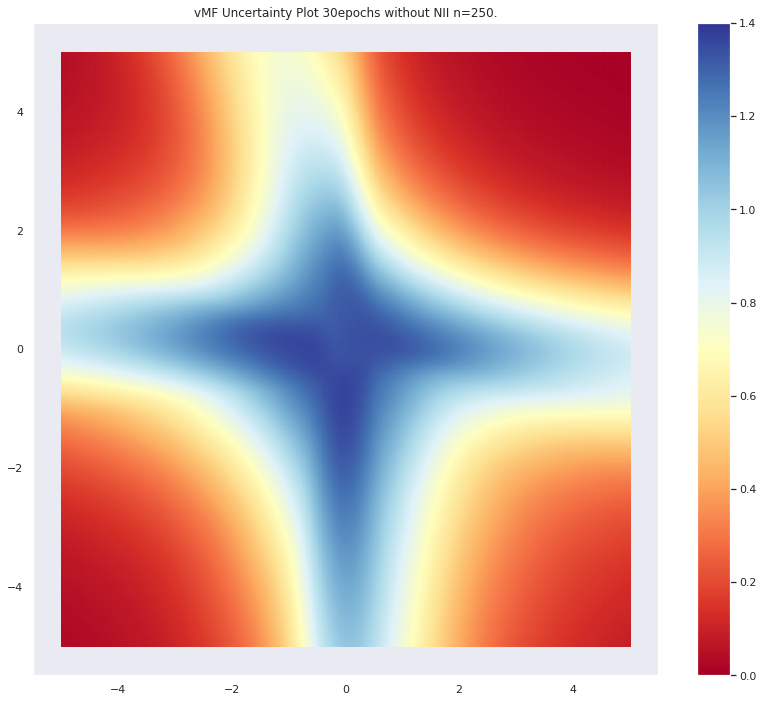

torch.Size([1056784, 5])


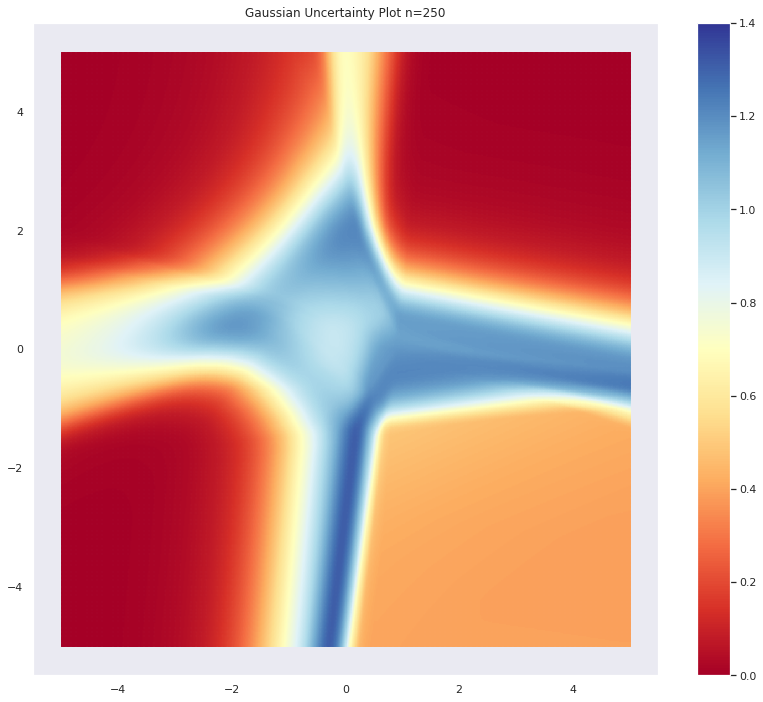

tensor(0.1592) tensor(2.2103e-12)


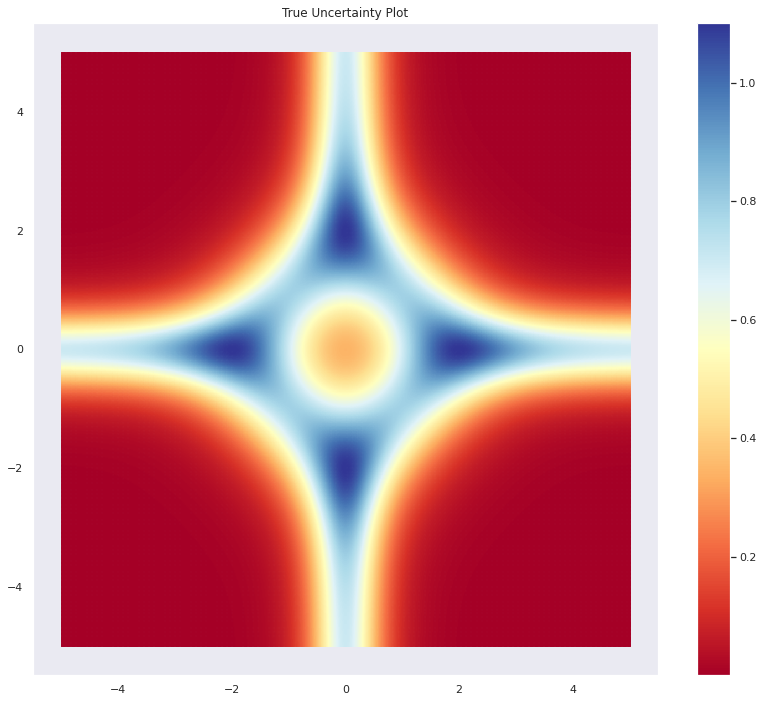

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42069)
torch.manual_seed(42069)

PL = [torch.Tensor([1-3, 1-3]),torch.Tensor([5-3, 1-3]),torch.Tensor([1-3, 5-3]),torch.Tensor([5-3, 5-3]),torch.Tensor([3-3, 3-3])]
cov = torch.eye(2)
n = 250

plt.figure(figsize=(10, 10), dpi=500)
distrib = []

DF = torch.zeros((len(PL),n,1,3)) #multiple of 4
for i, MU in enumerate(PL): #enumerate starts from and including 0.
    distrib.append(torch.distributions.multivariate_normal.MultivariateNormal(loc=MU, covariance_matrix=cov))
    DATA_ = distrib[i].sample((n,1))

    DATA  = torch.zeros([n, 1, 3])
    DATA[:,:,:2] = DATA_
    DATA[:,:,2]  = i
    DF[i,:,:,:] = DATA
    
    x = DATA[:,0,0]
    y = DATA[:,0,1]
    plt.plot(x,y,'.',markersize=1.25)
plt.show()

C = int(3*n/4)

#DATA_train = torch.zeros((len(PL)*C,3))
#DATA_test = torch.zeros((len(PL)*(n-C),3))

DATA = DF.reshape(len(PL)*n,3)
#print('DATA:',DATA,'len(DATA):',len(DATA),'mean dtrain:',DATA.mean(axis=0)[2])

#data_mean = DATA.mean(axis=1)[0:2]
#data_std = DATA.std(axis=1)[0:2]

#DATA[:,0:2] = (DATA[:,0:2]  - data_mean)/data_std
#print('DATA normalized:',DATA,'len(DATA) normalized:',len(DATA),'mean dtrain normalized:',DATA.mean(axis=0)[2])
tr_ids = np.random.choice(n*5, n*4, replace = False)



dtrain = DATA[tr_ids,:]
dtest = DATA[-tr_ids,:]


#print('\n','dtrain:',dtrain, 'len(dtrain):',len(dtrain),'mean dtrain:',dtrain.mean(axis=0)[2])
#print('\n','dtest:',dtest, 'len(dtest):',len(dtest),'mean dtest:',dtest.mean(axis=0)[2])

import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib


import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

# define the summary writer
writer = SummaryWriter()
# select the device
DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)

# define the parameters

COND_OPT = False
CLASSES = 5
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50
TEST_BATCH_SIZE = 100
BATCH_SIZE = 100

l1shape=(2, 5)
l2shape=(5, 5)
l3shape=(5, 5)
l4shape=(5, 5)
l5shape=(5, 5)
l6shape=(5, 5)
layershapes = [l1shape, l2shape, l3shape, l4shape]

# set prior parameters
PI = 1
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])
data_shape = (0,2,2,3)

epochs = 30
trtimes = []
#w_mu = [w_mu1, w_mu2, w_mu3, w_mu4]
#b_mu = [b_mu1, b_mu2, b_mu3, b_mu4]

#w_mu_nodewise = [w_mu1_nodewise,w_mu2_nodewise,w_mu3_nodewise,w_mu4_nodewise]
#b_mu_nodewise = [b_mu1_nodewise,b_mu2_nodewise,b_mu3_nodewise,b_mu4_nodewise]
# make inference on 10 networks

for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net3 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                #w_kappa=torch.Tensor(1).uniform_(6,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net3.parameters(), lr=0.04)
    
    
    for epoch in range(epochs):
        
        train = FVMF.train(net3, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net3.weight_mu[1].max())
        print('norm:',torch.norm(net3.weight_mu[1]))

    res = test_ensemble.test_ensemble(net3,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 30
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    netSimNoIIN = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(netSimNoIIN.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(netSimNoIIN, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    res = test_ensemble.test_ensemble(netSimNoIIN,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 10
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men doble? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag.

w_mu = []
for i in range(len(net4.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4.weight_mu[i]/torch.norm(net4.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4.bias_mu[i]/torch.norm(net4.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4.bias_rho)):
    b_rho.append(net4.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4.weight_rho)):
    w_rho.append(net4.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4_GC,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
#print('This is the loss with the Gradient Capture method/Normalized Initialization Inheritance')

#Ok, så kanskje drit i gradient-capture-method. Men! Husk hva du har vist her nå med kun normalisering av vektene, Du får trent nettet
#Videre, og det fungerer faktisk. I tilfellet hvor du ikke gjør det ender du faktisk ikke bare opp med dårlig ytelse, men
#hele nettet brekker!!!!!!!!!!!

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

w_mu = []
for i in range(len(net4_GC.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4_GC.weight_mu[i]/torch.norm(net4_GC.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4_GC.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4_GC.bias_mu[i]/torch.norm(net4_GC.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4_GC.bias_rho)):
    b_rho.append(net4_GC.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4_GC.weight_rho)):
    w_rho.append(net4_GC.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC2.parameters(), lr=0.035)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    res = test_ensemble.test_ensemble(net4_GC2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
print('This is the loss with the Gradient Capture method/Normalized Initialization Inheritance, applied twice')

#Ok, så kanskje drit i gradient-capture-method. Men! Husk hva du har vist her nå med kun normalisering av vektene, Du får trent nettet
#Videre, og det fungerer faktisk. I tilfellet hvor du ikke gjør det ender du faktisk ikke bare opp med dårlig ytelse, men
#hele nettet brekker!!!!!!!!!!!

RES = 1028 #Ca. Full HD resolution. If you struggle with memory adjust this parameter down. 64 for example already gives a decent view.
enums = 10

DEVICE = torch.device("cuda:1")
Temps = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net4_GC2(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

plt.title('vMF Uncertainty Plot 3*10epochs with NII n=250.')
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMFNII_Uncertainty_Plotn250.png')
plt.show()




Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(netSimNoIIN(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

plt.title('vMF Uncertainty Plot 30epochs without NII n=250.')
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMF_non_NII_Uncertainty_Plotn250.png')
plt.show()





RES = 1028
enums = 10

DEVICE = torch.device("cuda:1")
Temps2 = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps2[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net3(Temps2[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps2[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(probs.shape)

plt.title('Gaussian Uncertainty Plot n=250')
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot2 = plt.scatter(Temps2[:,0].detach().numpy(), Temps2[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps2[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot2)
plt.savefig('Plots/Gaussian_Uncertainty_Plotn250.png')
plt.show()

#All of the variables should be defined earlier, to be certain we are comparing the same things in our plots.
RES = 1028
DEVICE = torch.device("cuda:1")
Temps4 = torch.zeros((RES**2,3))

x = torch.linspace(-5,5,RES)
Temps4[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((RES**2, 5)).to(DEVICE)


#print(distributions[i].log_prob(Temps4[:,0:2]).shape)
sfm = torch.nn.Softmax(dim = -1)

VAL = torch.zeros((RES**2,5)).to(DEVICE)
for i in range(len(distrib)):
    VAL[:,i] = distrib[i].log_prob(Temps4[:,0:2]) #Does the log_prob method really do exactly what I want?

VAL2 = torch.zeros((RES**2,5)).to(DEVICE)
VAL2 = sfm(VAL)
#mc = torch.min(VAL,dim = 1).values    
#nc = torch.sum(VAL-mc,dim = 1)

      
#for i in range(len(distrib)):
#    VAL[:,i] =  VAL[:,i]-mc)/nc[i]
    
Temps4[:,2] = -torch.sum(torch.log(VAL2) * VAL2,dim = 1) #We don't log the probs here, since they were already logged.


#print(VAL.shape)
#print(torch.exp(net3(Temps2[:,0:2])).shape)
print(max(torch.exp(distrib[i].log_prob(Temps4[:,0:2]))),min(torch.exp(distrib[i].log_prob(Temps4[:,0:2]))))

plt.title('True Uncertainty Plot')
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot4 = plt.scatter(Temps4[:,0].detach().numpy(), Temps4[:,1].detach().numpy(), s=221000/(RES**2), c=Temps4[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot4)
plt.savefig('Plots/True_Uncertainty_Plot.png')
plt.show()

In [3]:
#net4.state_dict()
#print(net4.state_dict()['layers.3.weight_mu'])
#get a bar for the range of the entropy scalar.
#Center data around 0.

#Simuler marginalfordeling for en vekt fra vMF. OG sammenlign med en marginal vekt fra multivariat Gaussisk som har blitt normalisert.
#og hva skjer i posterioren etter det er trent. trekk vekter fra HU, gjør forwardpass predictions som simulert data, tren på det og sjekk om vektene blir som i starten.
#Hva med å initialisere fra HU!!!???

#Siden W_kappa initialiseres så høyt, er det jo ikke så rart at vMF-en generelt er mye mindre selvsikker enn den Gaussiske.
#Da er det også forståelig, at ettersom vi øker w_kappa, så må vi også øke læringsraten, siden forandringen i likelihood
#loss ved weight_mu justering blir mindre intens. Kanskje er også noe av grunnen til at vi blir tvunget til så høye kappa,
#At nettet ikke klarer å finne noen gradient descent ellers? Siden hvis vi er langt unna der W-mu skulle vært, så får vi nesten
#ikke noen forandring i loss? Hva med en tostegs-trening, hvor vi først trener med høy kappa. Og så initialiserer vi fra de foregående
#W og b muene, men med nye tilfeldige kappa som er mye mindre?? Det høres ut som en god ide!

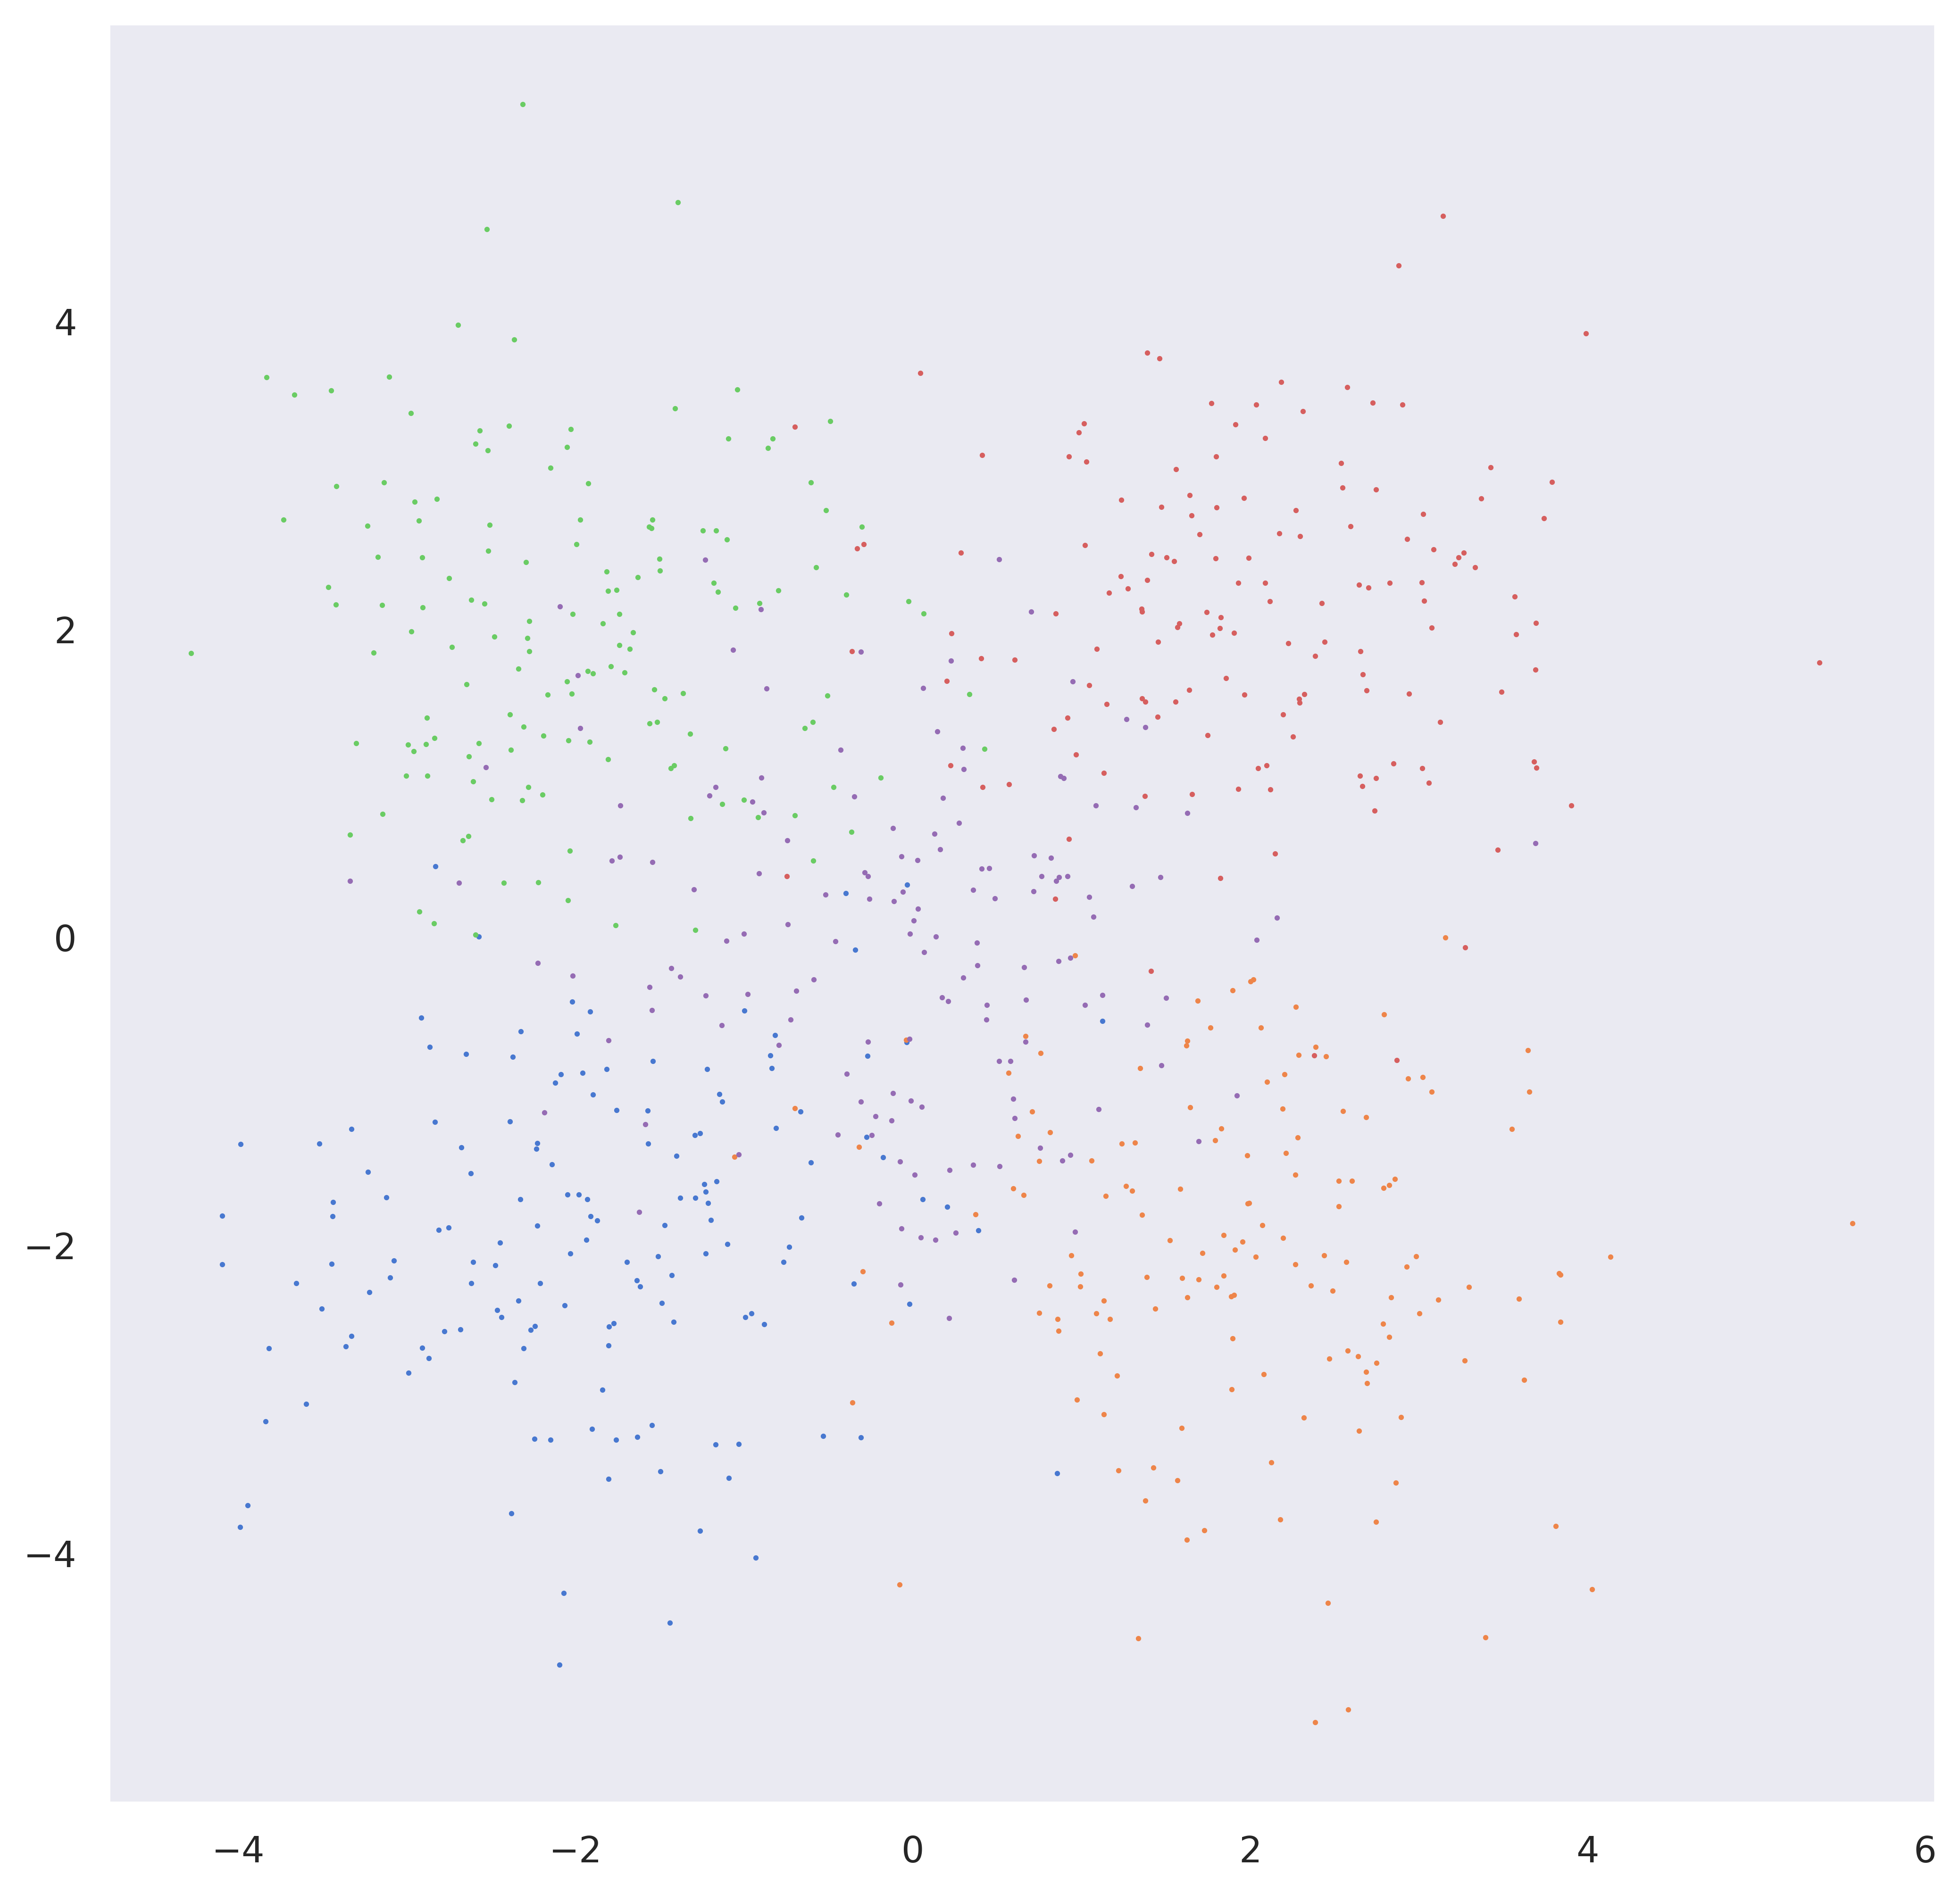

GPUs are used!
FVMF RELOADED
0
Random Init Utilized
1
loss: tensor(223.2921, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(158.0703, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.3951, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(0.7006, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(202.0611, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(138.5149, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.6271, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(1.3457, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(190.6782, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(132.7158, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.6759, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(1.5346, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(182.9703, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(129.3638, device='c

Component 0 Accuracy: 489.0/600
Component 1 Accuracy: 483.0/600
Component 2 Accuracy: 483.0/600
Component 3 Accuracy: 470.0/600
Component 4 Accuracy: 479.0/600
Component 5 Accuracy: 483.0/600
Component 6 Accuracy: 473.0/600
Component 7 Accuracy: 482.0/600
Component 8 Accuracy: 476.0/600
Component 9 Accuracy: 483.0/600
Posterior Mean Accuracy: 490.0/600
Ensemble Accuracy: 484/600
0
Random Init Utilized
1
loss: tensor(168.7845, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(149.5400, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(163.9088, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(146.9119, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(168.5573, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(148.8850, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(163.0511, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(142.5223, device='cuda:1', grad_fn=<Nl

10
loss: tensor(99.6908, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(79.0831, device='cuda:1', grad_fn=<NllLossBackward0>)
0
1
loss: tensor(125.0457, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(102.6868, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(106.9214, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(86.8509, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(102.2655, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(80.1633, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(101.2563, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(80.3349, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(99.7639, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(79.5378, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(101.6745, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelih

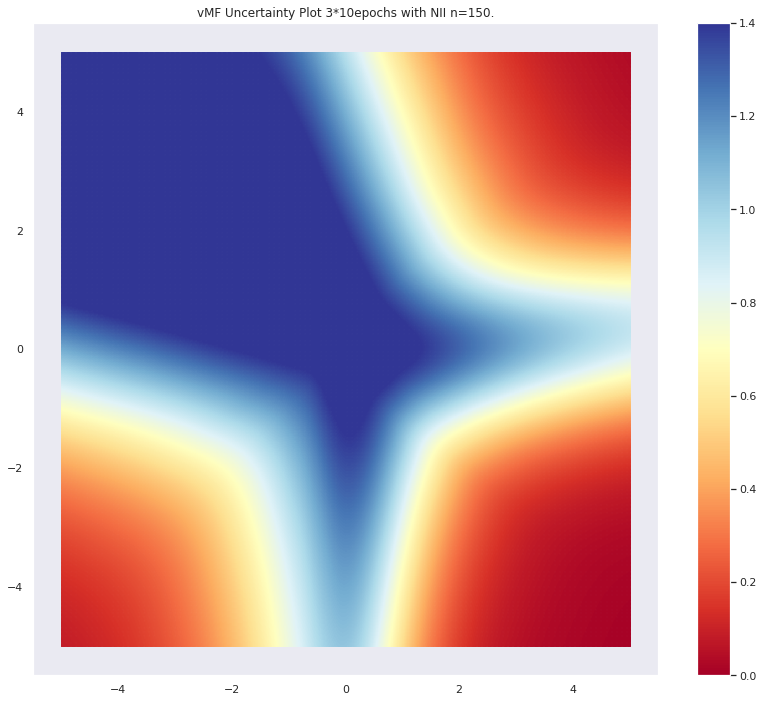

tensor(1.3712, grad_fn=<MaxBackward1>) tensor(0.0165, grad_fn=<MinBackward1>)


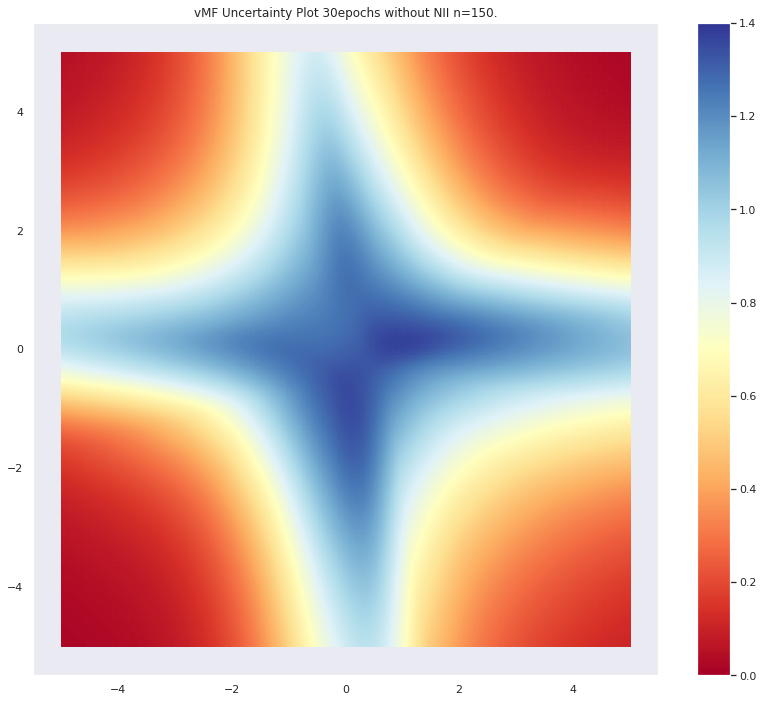

torch.Size([1056784, 5])


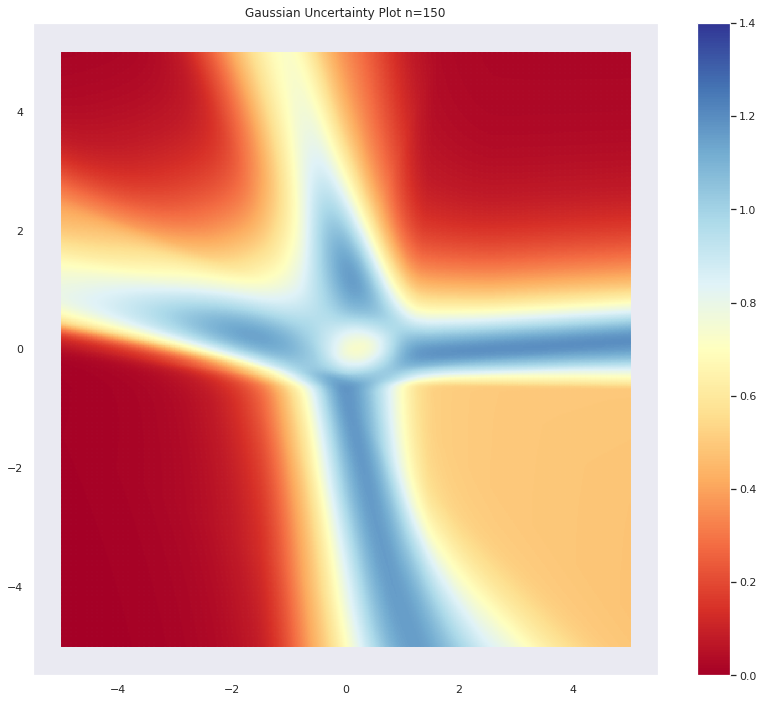

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42069)
torch.manual_seed(42069)

PL = [torch.Tensor([1-3, 1-3]),torch.Tensor([5-3, 1-3]),torch.Tensor([1-3, 5-3]),torch.Tensor([5-3, 5-3]),torch.Tensor([3-3, 3-3])]
cov = torch.eye(2)
n = 150

plt.figure(figsize=(10, 10), dpi=500)
distrib = []

DF = torch.zeros((len(PL),n,1,3)) #multiple of 4
for i, MU in enumerate(PL): #enumerate starts from and including 0.
    distrib.append(torch.distributions.multivariate_normal.MultivariateNormal(loc=MU, covariance_matrix=cov))
    DATA_ = distrib[i].sample((n,1))

    DATA  = torch.zeros([n, 1, 3])
    DATA[:,:,:2] = DATA_
    DATA[:,:,2]  = i
    DF[i,:,:,:] = DATA
    
    x = DATA[:,0,0]
    y = DATA[:,0,1]
    plt.plot(x,y,'.',markersize=1.25)
plt.show()

C = int(3*n/4)

#DATA_train = torch.zeros((len(PL)*C,3))
#DATA_test = torch.zeros((len(PL)*(n-C),3))

DATA = DF.reshape(len(PL)*n,3)
#print('DATA:',DATA,'len(DATA):',len(DATA),'mean dtrain:',DATA.mean(axis=0)[2])

#data_mean = DATA.mean(axis=1)[0:2]
#data_std = DATA.std(axis=1)[0:2]

#DATA[:,0:2] = (DATA[:,0:2]  - data_mean)/data_std
#print('DATA normalized:',DATA,'len(DATA) normalized:',len(DATA),'mean dtrain normalized:',DATA.mean(axis=0)[2])
tr_ids = np.random.choice(n*5, n*4, replace = False)



dtrain = DATA[tr_ids,:]
dtest = DATA[-tr_ids,:]


#print('\n','dtrain:',dtrain, 'len(dtrain):',len(dtrain),'mean dtrain:',dtrain.mean(axis=0)[2])
#print('\n','dtest:',dtest, 'len(dtest):',len(dtest),'mean dtest:',dtest.mean(axis=0)[2])

import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib


import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

# define the summary writer
writer = SummaryWriter()
# select the device
DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)

# define the parameters

COND_OPT = False
CLASSES = 5
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50
TEST_BATCH_SIZE = 100
BATCH_SIZE = 100

l1shape=(2, 5)
l2shape=(5, 5)
l3shape=(5, 5)
l4shape=(5, 5)
l5shape=(5, 5)
l6shape=(5, 5)
layershapes = [l1shape, l2shape, l3shape, l4shape]

# set prior parameters
PI = 1
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])
data_shape = (0,2,2,3)

epochs = 30
trtimes = []
#w_mu = [w_mu1, w_mu2, w_mu3, w_mu4]
#b_mu = [b_mu1, b_mu2, b_mu3, b_mu4]

#w_mu_nodewise = [w_mu1_nodewise,w_mu2_nodewise,w_mu3_nodewise,w_mu4_nodewise]
#b_mu_nodewise = [b_mu1_nodewise,b_mu2_nodewise,b_mu3_nodewise,b_mu4_nodewise]
# make inference on 10 networks

for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net3 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                #w_kappa=torch.Tensor(1).uniform_(6,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net3.parameters(), lr=0.04)
    
    
    for epoch in range(epochs):
        
        train = FVMF.train(net3, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net3.weight_mu[1].max())
        print('norm:',torch.norm(net3.weight_mu[1]))
    print('\n','Testacc Gaussian 150:')
    res = test_ensemble.test_ensemble(net3,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 30
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    netSimNoIIN = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(netSimNoIIN.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(netSimNoIIN, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))
    print('\n','Testacc for non-NII vMF 150:')
    res = test_ensemble.test_ensemble(netSimNoIIN,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 10
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men doble? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag.

w_mu = []
for i in range(len(net4.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4.weight_mu[i]/torch.norm(net4.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4.bias_mu[i]/torch.norm(net4.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4.bias_rho)):
    b_rho.append(net4.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4.weight_rho)):
    w_rho.append(net4.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4_GC,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
#print('This is the loss with the Gradient Capture method/Normalized Initialization Inheritance')

#Ok, så kanskje drit i gradient-capture-method. Men! Husk hva du har vist her nå med kun normalisering av vektene, Du får trent nettet
#Videre, og det fungerer faktisk. I tilfellet hvor du ikke gjør det ender du faktisk ikke bare opp med dårlig ytelse, men
#hele nettet brekker!!!!!!!!!!!

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

w_mu = []
for i in range(len(net4_GC.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4_GC.weight_mu[i]/torch.norm(net4_GC.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4_GC.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4_GC.bias_mu[i]/torch.norm(net4_GC.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4_GC.bias_rho)):
    b_rho.append(net4_GC.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4_GC.weight_rho)):
    w_rho.append(net4_GC.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC2.parameters(), lr=0.035)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))
    print('\n','Testacc for NII vMF 150:')
    res = test_ensemble.test_ensemble(net4_GC2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

#Ok, så kanskje drit i gradient-capture-method. Men! Husk hva du har vist her nå med kun normalisering av vektene, Du får trent nettet
#Videre, og det fungerer faktisk. I tilfellet hvor du ikke gjør det ender du faktisk ikke bare opp med dårlig ytelse, men
#hele nettet brekker!!!!!!!!!!!

RES = 1028 #Ca. Full HD resolution. If you struggle with memory adjust this parameter down. 64 for example already gives a decent view.
enums = 10

DEVICE = torch.device("cuda:1")
Temps = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net4_GC2(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

plt.title('vMF Uncertainty Plot 3*10epochs with NII n=150.')
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMFNII_Uncertainty_Plotn150.png')
plt.show()



Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(netSimNoIIN(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

plt.title('vMF Uncertainty Plot 30epochs without NII n=150.')
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMF_non_NII_Uncertainty_Plotn150.png')
plt.show()




RES = 1028
enums = 10

DEVICE = torch.device("cuda:1")
Temps2 = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps2[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net3(Temps2[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps2[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(probs.shape)

plt.title('Gaussian Uncertainty Plot n=150')
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot2 = plt.scatter(Temps2[:,0].detach().numpy(), Temps2[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps2[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot2)
plt.savefig('Plots/Gaussian_Uncertainty_Plotn150.png')
plt.show()

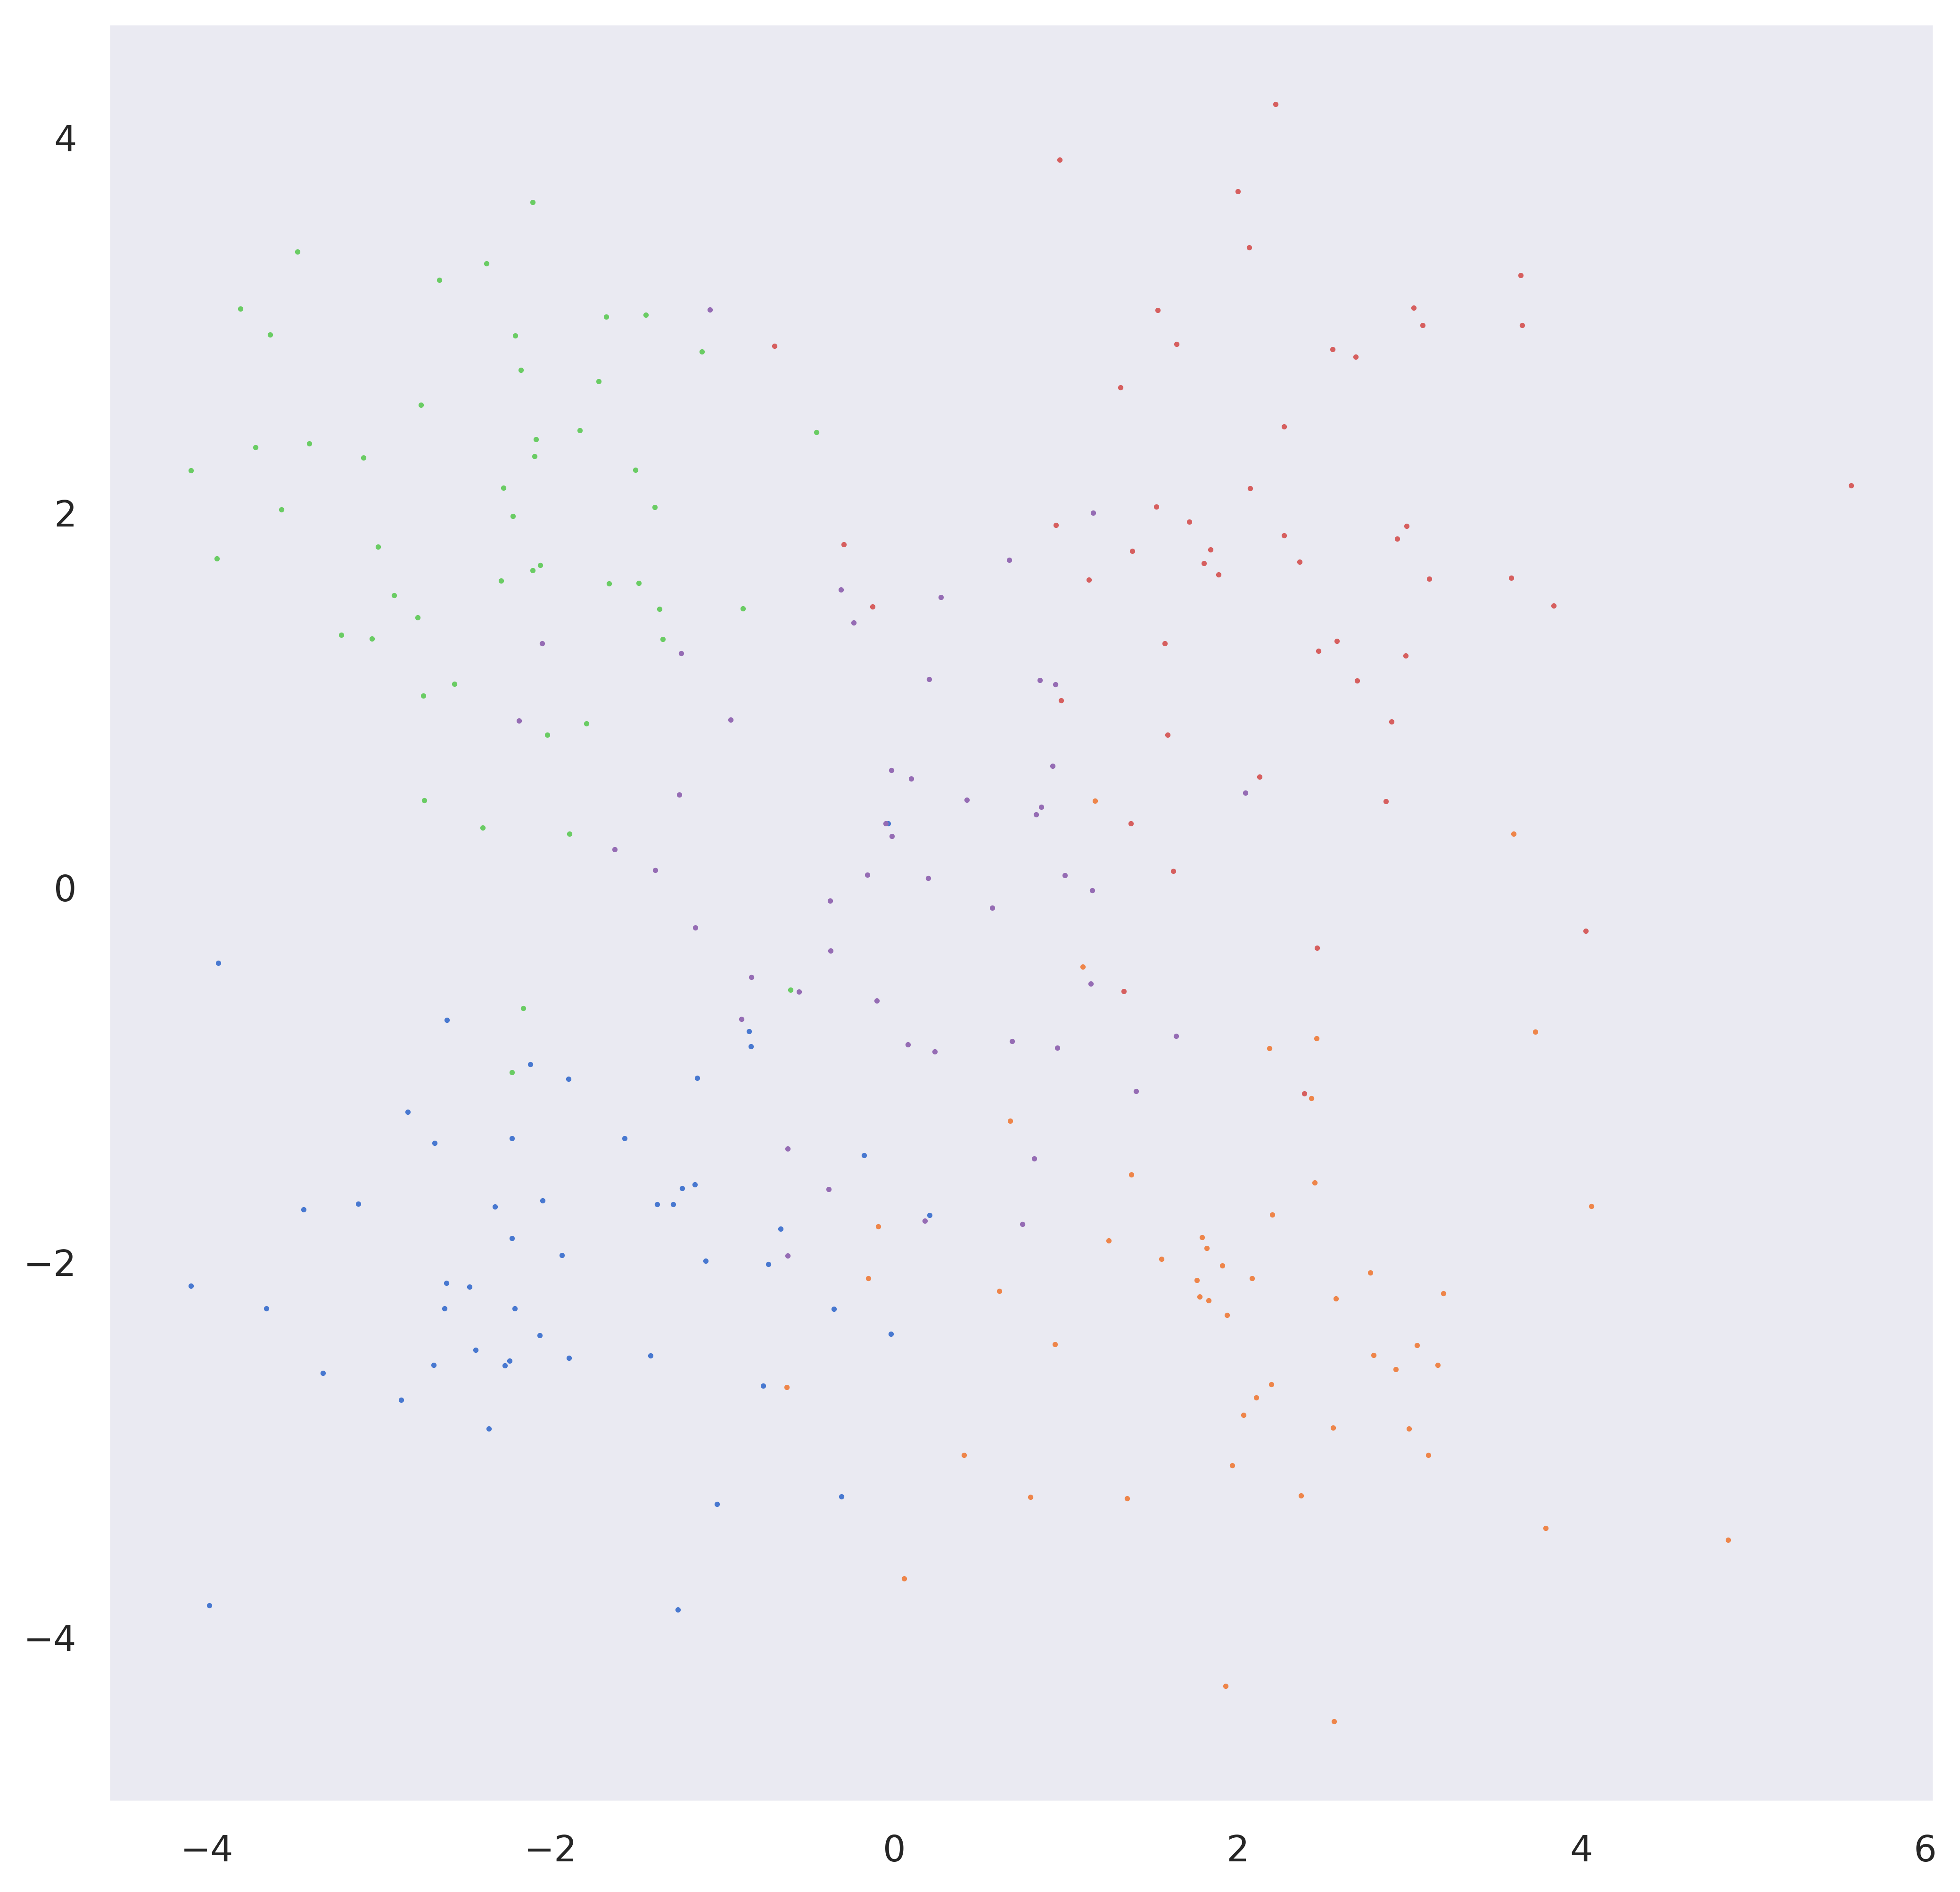

GPUs are used!
FVMF RELOADED
0
Random Init Utilized
1
loss: tensor(360.1822, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(161.0206, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.2513, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(0.4003, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(362.7167, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(160.7176, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.3170, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(0.4223, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(355.4470, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(159.9962, device='cuda:1', grad_fn=<NllLossBackward0>)
max: tensor(0.3869, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(0.5680, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(351.3536, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(157.6092, device='c

1
loss: tensor(207.0498, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(149.3496, device='cuda:1', grad_fn=<NllLossBackward0>)
2
loss: tensor(200.0735, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(142.0502, device='cuda:1', grad_fn=<NllLossBackward0>)
3
loss: tensor(199.9675, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(142.2340, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(196.7512, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(141.7046, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(194.9177, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(139.5752, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(187.8101, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(136.8246, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(192.4172, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_lik

3
loss: tensor(136.7793, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(77.1612, device='cuda:1', grad_fn=<NllLossBackward0>)
4
loss: tensor(141.0941, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(82.8930, device='cuda:1', grad_fn=<NllLossBackward0>)
5
loss: tensor(137.3334, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(81.8484, device='cuda:1', grad_fn=<NllLossBackward0>)
6
loss: tensor(129.9496, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(77.3349, device='cuda:1', grad_fn=<NllLossBackward0>)
7
loss: tensor(130.6195, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(74.7429, device='cuda:1', grad_fn=<NllLossBackward0>)
8
loss: tensor(128.6399, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(73.5392, device='cuda:1', grad_fn=<NllLossBackward0>)
9
loss: tensor(133.7929, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihoo

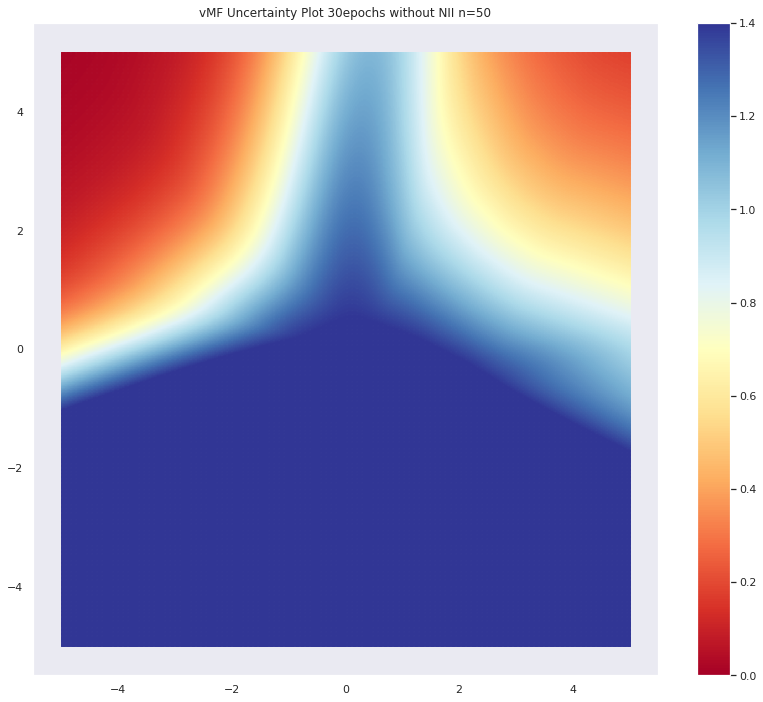

tensor(1.6001, grad_fn=<MaxBackward1>) tensor(0.0156, grad_fn=<MinBackward1>)


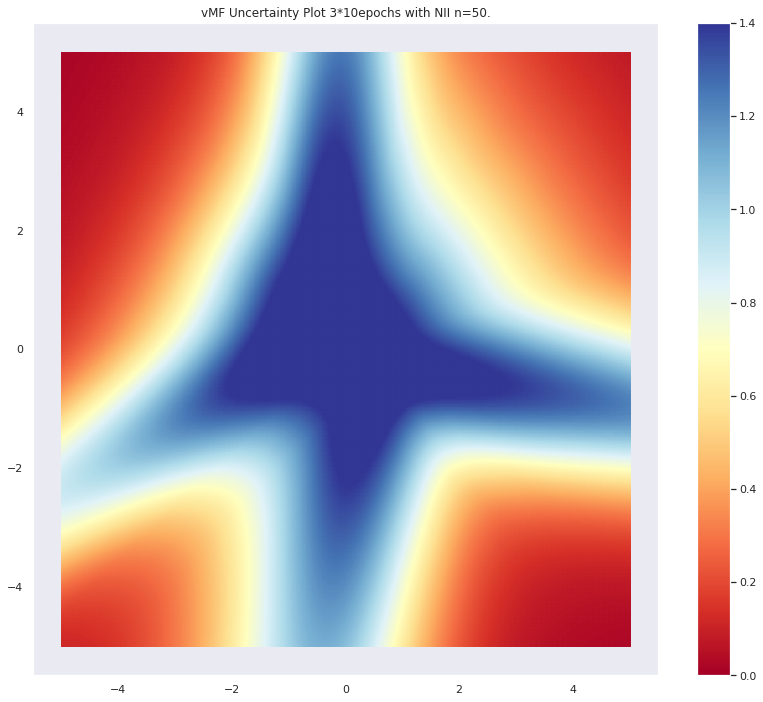

torch.Size([1056784, 5])


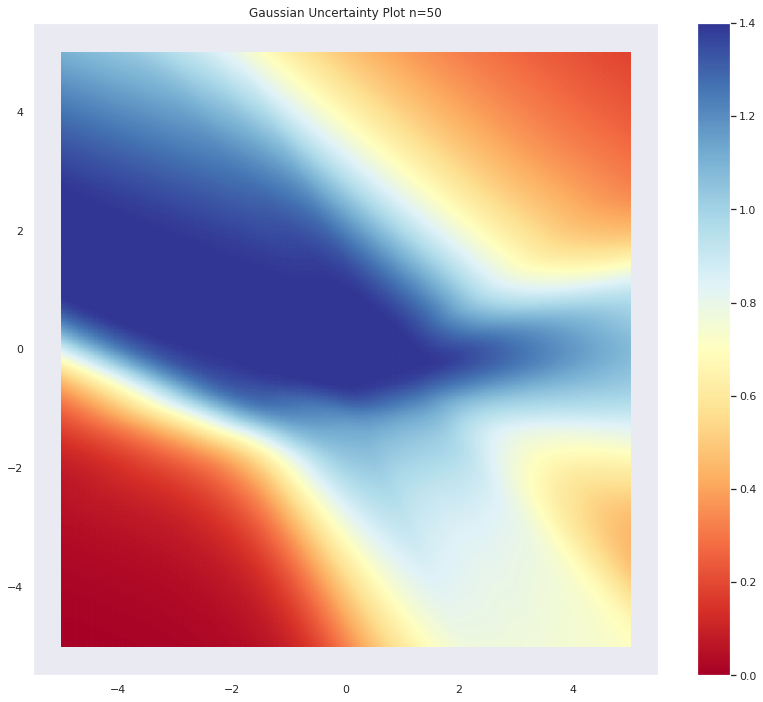

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42069)
torch.manual_seed(42069)

PL = [torch.Tensor([1-3, 1-3]),torch.Tensor([5-3, 1-3]),torch.Tensor([1-3, 5-3]),torch.Tensor([5-3, 5-3]),torch.Tensor([3-3, 3-3])]
cov = torch.eye(2)
n = 50

plt.figure(figsize=(10, 10), dpi=500)
distrib = []

DF = torch.zeros((len(PL),n,1,3)) #multiple of 4
for i, MU in enumerate(PL): #enumerate starts from and including 0.
    distrib.append(torch.distributions.multivariate_normal.MultivariateNormal(loc=MU, covariance_matrix=cov))
    DATA_ = distrib[i].sample((n,1))

    DATA  = torch.zeros([n, 1, 3])
    DATA[:,:,:2] = DATA_
    DATA[:,:,2]  = i
    DF[i,:,:,:] = DATA
    
    x = DATA[:,0,0]
    y = DATA[:,0,1]
    plt.plot(x,y,'.',markersize=1.25)
plt.show()

C = int(3*n/4)

#DATA_train = torch.zeros((len(PL)*C,3))
#DATA_test = torch.zeros((len(PL)*(n-C),3))

DATA = DF.reshape(len(PL)*n,3)
#print('DATA:',DATA,'len(DATA):',len(DATA),'mean dtrain:',DATA.mean(axis=0)[2])

#data_mean = DATA.mean(axis=1)[0:2]
#data_std = DATA.std(axis=1)[0:2]

#DATA[:,0:2] = (DATA[:,0:2]  - data_mean)/data_std
#print('DATA normalized:',DATA,'len(DATA) normalized:',len(DATA),'mean dtrain normalized:',DATA.mean(axis=0)[2])
tr_ids = np.random.choice(n*5, n*4, replace = False)



dtrain = DATA[tr_ids,:]
dtest = DATA[-tr_ids,:]


#print('\n','dtrain:',dtrain, 'len(dtrain):',len(dtrain),'mean dtrain:',dtrain.mean(axis=0)[2])
#print('\n','dtest:',dtest, 'len(dtest):',len(dtest),'mean dtest:',dtest.mean(axis=0)[2])

import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib


import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

# define the summary writer
writer = SummaryWriter()
# select the device
DEVICE = torch.device("cuda:1")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
cuda = torch.cuda.set_device(1)

# define the parameters

COND_OPT = False
CLASSES = 5
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 50
TEST_BATCH_SIZE = 100
BATCH_SIZE = 100

l1shape=(2, 5)
l2shape=(5, 5)
l3shape=(5, 5)
l4shape=(5, 5)
l5shape=(5, 5)
l6shape=(5, 5)
layershapes = [l1shape, l2shape, l3shape, l4shape]

# set prior parameters
PI = 1
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])
data_shape = (0,2,2,3)

epochs = 30
trtimes = []
#w_mu = [w_mu1, w_mu2, w_mu3, w_mu4]
#b_mu = [b_mu1, b_mu2, b_mu3, b_mu4]

#w_mu_nodewise = [w_mu1_nodewise,w_mu2_nodewise,w_mu3_nodewise,w_mu4_nodewise]
#b_mu_nodewise = [b_mu1_nodewise,b_mu2_nodewise,b_mu3_nodewise,b_mu4_nodewise]
# make inference on 10 networks

for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net3 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(4,4.1),
                                #w_kappa=torch.Tensor(1).uniform_(6,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net3.parameters(), lr=0.04)
    
    
    for epoch in range(epochs):
        
        train = FVMF.train(net3, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        
        print('max:',net3.weight_mu[1].max())
        print('norm:',torch.norm(net3.weight_mu[1]))
    print('\n','Testacc Gaussian 50:')
    res = test_ensemble.test_ensemble(net3,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 30
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    netSimNoIIN = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(netSimNoIIN.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(netSimNoIIN, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))
    print('\n','Testacc for non-NII vMF 50:')
    res = test_ensemble.test_ensemble(netSimNoIIN,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

epochs = 10
trtimes = []
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4 = FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(4.0,4.1),
                                w_kappa=torch.Tensor(1).uniform_(6.0,6.1),
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4.parameters(), lr=0.14)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men doble? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag.

w_mu = []
for i in range(len(net4.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4.weight_mu[i]/torch.norm(net4.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4.bias_mu[i]/torch.norm(net4.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4.bias_rho)):
    b_rho.append(net4.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4.weight_rho)):
    w_rho.append(net4.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC.parameters(), lr=0.07)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    #res = test_ensemble.test_ensemble(net4_GC,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")
#print('This is the loss with the Gradient Capture method/Normalized Initialization Inheritance')

#Ok, så kanskje drit i gradient-capture-method. Men! Husk hva du har vist her nå med kun normalisering av vektene, Du får trent nettet
#Videre, og det fungerer faktisk. I tilfellet hvor du ikke gjør det ender du faktisk ikke bare opp med dårlig ytelse, men
#hele nettet brekker!!!!!!!!!!!

GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

w_mu = []
for i in range(len(net4_GC.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu.append(net4_GC.weight_mu[i]/torch.norm(net4_GC.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu = []
for i in range(len(net4_GC.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu.append(net4_GC.bias_mu[i]/torch.norm(net4_GC.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho= []
for i in range(len(net4_GC.bias_rho)):
    b_rho.append(net4_GC.bias_rho[i]*GC_intensity)

w_rho= []
for i in range(len(net4_GC.weight_rho)):
    w_rho.append(net4_GC.weight_rho[i]*GC_intensity)

#print('b_rho:',b_rho, '\n','w_rho:',b_mu)

epochs = 10
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net4_GC2 = FVMF.BayesianNetwork(w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dtrain, dtest=dtest,
                                VD='vmf',
                                b_kappa= b_rho, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'classification')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net4_GC2.parameters(), lr=0.035)
    
    
    for epoch in range(epochs):

        train = FVMF.train(net4_GC2, dtrain, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,shape = data_shape)
        trtimes.append(train[1].detach().cpu().numpy())#print('max:',net4.weight_mu[1].max())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))
    print('\n','Testacc for NII vMF 50:')
    res = test_ensemble.test_ensemble(net4_GC2,dtest,TEST_SAMPLES,TEST_BATCH_SIZE,BATCH_SIZE,CLASSES,DEVICE,shape = data_shape)

    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

#Ok, så kanskje drit i gradient-capture-method. Men! Husk hva du har vist her nå med kun normalisering av vektene, Du får trent nettet
#Videre, og det fungerer faktisk. I tilfellet hvor du ikke gjør det ender du faktisk ikke bare opp med dårlig ytelse, men
#hele nettet brekker!!!!!!!!!!!

RES = 1028 #Ca. Full HD resolution. If you struggle with memory adjust this parameter down. 64 for example already gives a decent view.
enums = 10

DEVICE = torch.device("cuda:1")
Temps = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(netSimNoIIN(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

plt.title('vMF Uncertainty Plot 30epochs without NII n=50')
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMF_Uncertainty_Plot_n50.png')
plt.show()

RES = 1028 #Ca. Full HD resolution. If you struggle with memory adjust this parameter down. 64 for example already gives a decent view.
enums = 10

DEVICE = torch.device("cuda:1")
Temps = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net4_GC2(Temps[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(torch.max(Temps[:,2]),torch.min(Temps[:,2]))

plt.title('vMF Uncertainty Plot 3*10epochs with NII n=50.')
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot = plt.scatter(Temps[:,0].detach().numpy(), Temps[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot)
plt.savefig('Plots/vMFNII_Uncertainty_Plotn50.png')
plt.show()


RES = 1028
enums = 10

DEVICE = torch.device("cuda:1")
Temps2 = torch.zeros((RES**2,3))
i, j = 0, 0

x = torch.linspace(-5,5,RES)

Temps2[:,:2] = torch.cartesian_prod(x, x)
probs = torch.zeros((1,5)).to(DEVICE)

for j in range(enums):
    probs = probs + torch.exp(net3(Temps2[:,0:2])) #This is done enums times, each one will be different due to stochastic.
probs = probs/enums

Temps2[:,2] = -torch.sum(probs * torch.log(probs),dim = 1)
print(probs.shape)

plt.title('Gaussian Uncertainty Plot n=50')
#xy = [0,0.2,0.4,0.6,0.8,1]
#z = xy
plot2 = plt.scatter(Temps2[:,0].detach().numpy(), Temps2[:,1].detach().numpy(),vmin = 0, vmax = 1.4, s=221000/(RES**2), c=Temps2[:,2].detach().numpy(), cmap='RdYlBu', marker='s')
plt.gcf().set_size_inches((14, 12))
plt.colorbar(plot2)
plt.savefig('Plots/Gaussian_Uncertainty_Plotn50.png')
plt.show()

In [1]:
import pandas as pd
import numpy as np
import torch
DATA = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00448/carbon_nanotubes.csv',sep = ';', decimal=",")
#This is the carbon nanotubes data.
DATA = DATA.astype(float)
#print(DATA)
#print(DATA)
DATA = DATA.to_numpy()
DATA = torch.from_numpy(DATA)
#print(DATA)
np.random.seed(42069)
#torch.manual_seed(42069)

DATA = DATA.type(torch.float32)

data_mean = DATA.mean(axis=1)[0:8]
data_std = DATA.std(axis=1)[0:8]
DEVICE = torch.device("cuda:1")

#DATA[:,7] = 5*DATA[:,1] + 3*DATA[:,6] + 2*DATA[:,3] + 1*DATA[:,2] 
DATA[:,0:8] = (DATA[:,0:8]  - data_mean)/data_std
#print('DATA normalized:',DATA,'len(DATA) normalized:',len(DATA),'mean dtrain normalized:',DATA.mean(axis=0)[2])
tr_ids = np.random.choice(10721, 6000, replace = False)

dTRAIN_CARBON = DATA[tr_ids,:]
dTEST_CARBON = DATA[-tr_ids,:]

print(DATA)

tensor([[ 2.0375e+00,  3.9931e-01,  1.4072e-01,  ..., -3.8084e-02,
         -5.6848e-04, -1.1847e+00],
        [ 2.0375e+00,  3.9931e-01,  2.0051e-01,  ..., -7.3575e-03,
         -1.3260e-01, -8.2473e-01],
        [ 2.0375e+00,  3.9931e-01, -1.5547e-01,  ..., -4.6846e-01,
         -8.3970e-01, -1.0649e+00],
        ...,
        [ 1.8122e+01,  9.3640e+00,  5.2303e-01,  ...,  3.3039e-01,
         -2.7718e-01,  1.5732e-01],
        [ 1.8122e+01,  9.3640e+00,  5.4044e-01,  ...,  3.5240e-01,
         -2.1551e-01,  3.5602e-01],
        [ 1.8122e+01,  9.3640e+00,  5.6962e-01,  ...,  3.8670e-01,
         -4.0853e-02,  3.9589e-01]])


In [2]:
import math
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
import pandas as pd
import time
import mpmath
import os
import importlib

COND_OPT = False
CLASSES = 1
# TRAIN_EPOCHS = 250
SAMPLES = 1
TEST_SAMPLES = 10
TEMPER = 0.001
TEMPER_PRIOR = 0.001
pepochs = 30
epochs =10
TEST_BATCH_SIZE = 6000
BATCH_SIZE = 100

import test_ensemble
importlib.reload(test_ensemble)
import FVMF
importlib.reload(FVMF)

data_shape = (0,7,7,8)
l1shape=(7, 7)
l2shape=(7, 7)
l3shape=(7, 7)
l4shape=(7, 1)
layershapes = [l1shape, l2shape, l3shape, l4shape]

trtimes  = []


for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net5= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                #w_kappa=torch.Tensor(1).uniform_(5,5.1),
                                Temper = 0.1,
                                classification='Regression')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net5.parameters(), lr=0.0007)
    
    
    for epoch in range(epochs):
        train = FVMF.train(net5, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))

    loss, outputs, output = test_ensemble.test_ensemble(net5,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('Gaussian 10 epoch')
    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

GPUs are used!
FVMF RELOADED
GPUs are used!
FVMF RELOADED
0
Random Init Utilized
1
loss: tensor(1.2491, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1212, device='cuda:1', grad_fn=<MeanBackward0>)
2
loss: tensor(1.2371, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1101, device='cuda:1', grad_fn=<MeanBackward0>)
3
loss: tensor(1.2343, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1055, device='cuda:1', grad_fn=<MeanBackward0>)
4
loss: tensor(1.2112, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1015, device='cuda:1', grad_fn=<MeanBackward0>)
5
loss: tensor(1.1772, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0983, device='cuda:1', grad_fn=<MeanBackward0>)
6
loss: tensor(1.1435, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0480, device='cuda:1', grad_fn=<MeanBackward0>)
7
loss: tensor(1.1265, device='cuda:1', gra

In [19]:
epochs = 30
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net5= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                #w_kappa=torch.Tensor(1).uniform_(5,5.1),
                                Temper = 0.1,
                                classification='Regression')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net5.parameters(), lr=0.0007)
    
    
    for epoch in range(epochs):
        train = FVMF.train(net5, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))
    
    loss, outputs, output = test_ensemble.test_ensemble(net5,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('Gaussian 30 epoch')

0
Random Init Utilized
1
loss: tensor(1.2491, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1212, device='cuda:1', grad_fn=<MeanBackward0>)
2
loss: tensor(1.2371, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1101, device='cuda:1', grad_fn=<MeanBackward0>)
3
loss: tensor(1.2343, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1055, device='cuda:1', grad_fn=<MeanBackward0>)
4
loss: tensor(1.2112, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1015, device='cuda:1', grad_fn=<MeanBackward0>)
5
loss: tensor(1.1772, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0983, device='cuda:1', grad_fn=<MeanBackward0>)
6
loss: tensor(1.1435, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0480, device='cuda:1', grad_fn=<MeanBackward0>)
7
loss: tensor(1.1265, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.030

In [23]:
epochs = 50
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    net5= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='Gaussian',
                                #b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                #w_kappa=torch.Tensor(1).uniform_(5,5.1),
                                Temper = 0.1,
                                classification='Regression')
    
    #for j,p in enumerate(net2.l1.parameters()):    
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(net5.parameters(), lr=0.0007)
    
    
    for epoch in range(epochs):
        train = FVMF.train(net5, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',net4.weight_mu[1].max())
        #print('norm:',torch.norm(net4.weight_mu[1]))
    
    loss, outputs, output = test_ensemble.test_ensemble(net5,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('Gaussian 50 epoch')

0
Random Init Utilized
1
loss: tensor(1.2491, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1212, device='cuda:1', grad_fn=<MeanBackward0>)
2
loss: tensor(1.2371, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1101, device='cuda:1', grad_fn=<MeanBackward0>)
3
loss: tensor(1.2343, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1055, device='cuda:1', grad_fn=<MeanBackward0>)
4
loss: tensor(1.2112, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1015, device='cuda:1', grad_fn=<MeanBackward0>)
5
loss: tensor(1.1772, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0983, device='cuda:1', grad_fn=<MeanBackward0>)
6
loss: tensor(1.1435, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0480, device='cuda:1', grad_fn=<MeanBackward0>)
7
loss: tensor(1.1265, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.030

In [24]:
trtimes  = []
epochs = 30

#Note, for this regression task, the last 7 to 1 layer has a Gaussian VD, where we kill the prior and simply optimize with MLE.
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression30= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                w_kappa=torch.Tensor(1).uniform_(7.5,7.6),
                                Temper = 0,classification='Regression',NODEFORCE =False)
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression.parameters(), lr=0.11)
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression30, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        print('max:',vMFRegression30.weight_mu[1].max())
        print('norm:',torch.norm(vMFRegression30.weight_mu[1]))

    loss, outputs, output = test_ensemble.test_ensemble(vMFRegression30,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('vMF 30 epoch')

0
Random Init Utilized
1
loss: tensor(0.2162, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.2162, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(1.9883, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(8.4469, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(0.5961, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.5961, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(1.9883, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(8.4469, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(0.3108, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.3108, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(1.9883, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(8.4469, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(0.5182, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.5182, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(1.9883, d

In [25]:
trtimes  = []
epochs = 50

#Note, for this regression task, the last 7 to 1 layer has a Gaussian VD, where we kill the prior and simply optimize with MLE.
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression50= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                w_kappa=torch.Tensor(1).uniform_(7.5,7.6),
                                Temper = 0,classification='Regression',NODEFORCE =False)
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression.parameters(), lr=0.11)
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression50, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        print('max:',vMFRegression30.weight_mu[1].max())
        print('norm:',torch.norm(vMFRegression30.weight_mu[1]))

    loss, outputs, output = test_ensemble.test_ensemble(vMFRegression50,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('vMF 50 epoch')

0
Random Init Utilized
1
loss: tensor(0.2162, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.2162, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(1.9883, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(8.4469, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(0.5961, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.5961, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(1.9883, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(8.4469, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(0.3108, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.3108, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(1.9883, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(8.4469, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(0.5182, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.5182, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(1.9883, d

KeyboardInterrupt: 

In [3]:
trtimes  = []


#Note, for this regression task, the last 7 to 1 layer has a Gaussian VD, where we kill the prior and simply optimize with MLE.
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression= FVMF.BayesianNetwork(#w_mu = w_mu, b_mu = b_mu, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='vmf',
                                b_kappa=torch.Tensor(1).uniform_(3,3.1),
                                w_kappa=torch.Tensor(1).uniform_(7.5,7.6),
                                Temper = 0,classification='Regression',NODEFORCE =False)
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression.parameters(), lr=0.11)
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        print('max:',vMFRegression.weight_mu[1].max())
        print('norm:',torch.norm(vMFRegression.weight_mu[1]))

    loss, outputs, output = test_ensemble.test_ensemble(vMFRegression,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('vMF 10 epoch')
    #np.savetxt("soundGmaccuracies_" + str(i) + ".csv", res, delimiter=",")

0
Random Init Utilized
1
loss: tensor(0.1516, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.1516, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.2483, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(9.6155, device='cuda:1', grad_fn=<NormBackward1>)
2
loss: tensor(0.0354, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0354, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.7255, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(9.8358, device='cuda:1', grad_fn=<NormBackward1>)
3
loss: tensor(0.0332, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0332, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(2.9328, device='cuda:1', grad_fn=<MaxBackward1>)
norm: tensor(10.0912, device='cuda:1', grad_fn=<NormBackward1>)
4
loss: tensor(0.0460, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0460, device='cuda:1', grad_fn=<MeanBackward0>)
max: tensor(3.2777, 

In [4]:
GC_intensity = 1

#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

w_mu_R = []
for i in range(len(vMFRegression.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu_R.append(vMFRegression.weight_mu[i]/torch.norm(vMFRegression.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu_R = []
for i in range(len(vMFRegression.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu_R.append(vMFRegression.bias_mu[i]/torch.norm(vMFRegression.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho_R= []
for i in range(len(vMFRegression.bias_rho)):
    b_rho_R.append(vMFRegression.bias_rho[i])

w_rho_R= []
for i in range(len(vMFRegression.weight_rho)):
    w_rho_R.append(vMFRegression.weight_rho[i])
#For some reason, it seems that the weights are not being properly normalized here. no actually they are, but the norm reported is the norm after 1 optimization step.

In [5]:
epochs = 20
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression2= FVMF.BayesianNetwork(w_mu = w_mu_R, b_mu = b_mu_R, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='vmf',
                                b_kappa= b_rho_R, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho_R, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'regression')
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression2.parameters(), lr=0.01) #0.01 9727 acc
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression2, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',vMFRegression2.weight_mu[1].max())
        #print('norm:',torch.norm(vMFRegression2.weight_mu[1]))

    loss, outputs, output = test_ensemble.test_ensemble(vMFRegression2,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('vMF 10+20 epoch NII')

0
1
loss: tensor(5.1579, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0081, device='cuda:1', grad_fn=<MeanBackward0>)
2
loss: tensor(5.0895, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0211, device='cuda:1', grad_fn=<MeanBackward0>)
3
loss: tensor(5.3428, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0896, device='cuda:1', grad_fn=<MeanBackward0>)
4
loss: tensor(5.5077, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0313, device='cuda:1', grad_fn=<MeanBackward0>)
5
loss: tensor(5.3614, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0047, device='cuda:1', grad_fn=<MeanBackward0>)
6
loss: tensor(5.1065, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0307, device='cuda:1', grad_fn=<MeanBackward0>)
7
loss: tensor(5.3507, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0185, device='cuda:1', g

In [6]:
#Kanskje er det en god idee å også arve kappaene, men halvere dem? Hva om vi også kjører på med litt normalizering av mu-ene her?
#Hva med adaptiv kappa per lag? Det er jo bare en kappa per bias-lag. GC fungerer rett og slett ikke.

w_mu_R = []
for i in range(len(vMFRegression2.weight_mu)):
    #print('\n','torch.norm(net4.weight_mu[i]):',torch.norm(net4.weight_mu[i]))
    w_mu_R.append(vMFRegression2.weight_mu[i]/torch.norm(vMFRegression2.weight_mu[i]))
    #print('\n','norm w_mu[i]',torch.norm(w_mu[i]))
    
b_mu_R = []
for i in range(len(vMFRegression2.bias_mu)):
    #print('\n','torch.norm(net4.bais_mu[i]):',torch.norm(net4.bias_mu[i]))
    b_mu_R.append(vMFRegression2.bias_mu[i]/torch.norm(vMFRegression2.bias_mu[i]))
    #print('\n','norm b_mu[i]',torch.norm(b_mu[i]))
    
b_rho_R= []
for i in range(len(vMFRegression2.bias_rho)):
    b_rho_R.append(vMFRegression2.bias_rho[i])

w_rho_R= []
for i in range(len(vMFRegression2.weight_rho)):
    w_rho_R.append(vMFRegression2.weight_rho[i])
#For some reason, it seems that the weights are not being properly normalized here. no actually they are, but the norm reported is the norm after 1 optimization step.

In [7]:
epochs = 20
for i in range(0, 1):
    print(i)
    torch.manual_seed(i)
    vMFRegression3= FVMF.BayesianNetwork(w_mu = w_mu_R, b_mu = b_mu_R, 
                                #w_mu = None, b_mu = None,
                                #w_mu = w_mu_nodewise, b_mu = b_mu,
                                layershapes = layershapes,
                                dtrain=dTRAIN_CARBON, dtest=dTEST_CARBON,
                                VD='vmf',
                                b_kappa= b_rho_R, #torch.Tensor(1).uniform_(1.0,3.1), 
                                w_kappa= w_rho_R, #torch.Tensor(1).uniform_(2.0,4.1), 
                                Temper = 1,classification = 'regression')
    
    #for j,p in enumerate(net2.l1.parameters()):
    #    p.requires_grad_(False)
    #    
    #for j,p in enumerate(net2.l2.parameters()):
    #    p.requires_grad_(False)
    
    optimizer = optim.Adam(vMFRegression2.parameters(), lr=0.004) #0.01 9727 acc
    
    
    for epoch in range(epochs):
        train = FVMF.train(vMFRegression3, dTRAIN_CARBON, SAMPLES, optimizer, epoch, i,BATCH_SIZE = 100,
                                    shape = data_shape,CLASSES = 1)    
        trtimes.append(train[1].detach().cpu().numpy())
        #print('max:',vMFRegression2.weight_mu[1].max())
        #print('norm:',torch.norm(vMFRegression2.weight_mu[1]))

    loss, outputs, output = test_ensemble.test_ensemble(vMFRegression3,dTEST_CARBON,TEST_SAMPLES,TEST_BATCH_SIZE,TEST_BATCH_SIZE,
                                      CLASSES,DEVICE,shape = data_shape,classification = False,plot = True)
    print('vMF 10+20+20 epoch NII')

0
1
loss: tensor(5.1699, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0032, device='cuda:1', grad_fn=<MeanBackward0>)
2
loss: tensor(5.1124, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0024, device='cuda:1', grad_fn=<MeanBackward0>)
3
loss: tensor(5.3331, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0190, device='cuda:1', grad_fn=<MeanBackward0>)
4
loss: tensor(5.5750, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0125, device='cuda:1', grad_fn=<MeanBackward0>)
5
loss: tensor(5.4593, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0071, device='cuda:1', grad_fn=<MeanBackward0>)
6
loss: tensor(5.2037, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0206, device='cuda:1', grad_fn=<MeanBackward0>)
7
loss: tensor(5.4933, device='cuda:1', grad_fn=<AddBackward0>)
negative_log_likelihood: tensor(0.0197, device='cuda:1', g

In [ ]:
g = [0,1,2,3,4,5]
for i,G, in enumerate(g):
    print('i:',i,'g:',G)
print(len(g))
i,j = True,True
if (i==1) or (j==1):
    print('The or statement in Python means and/or')
else:
    print('The or statement in Python means either or')

In [ ]:
#The RSS doesn't really vary much based on the number of epochs I administer. I suspect this to be either because we are not
#training the network correctly, or we are testing it incorrectly.

#Make many forward passes, and calculate the MSE on all of the forward passes!

#Also calculate the percentiles for them!

import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import torchvision.datasets as datasets
import os

cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [ ]:
#print(transforms.ToTensor(cifar_train))
print(cifar_train[0][0].shape)

In [ ]:
#Ok so this is actually not trivial... Maybe we need to place a convulutional layer first in order to properly parse this into
#our vMF so that we don't lose the positionality of our data?

In [ ]:
r"""
What if the problem is that since the mu's in the Gaussian is (out,in), and the vMF is out*in,
this could mean that we have "strethed" a single vMF pdf over all the parameters, while in the Gaussian we have made one for each output?

I don't know, also intuitively this should be the case, since the whole point of the vMF is the norm 1, which obviously
will require that it for each forward-pass is only one massive pdf for all inputs and outputs.

Ok, this can get rough, I will try my best to reshape the w_mu's and b_mu's the best I can, perhaps this will work just fine without too much tuning...
Hopefully.

This doe not seem to ave worked. I don't konw exactly what the problem is. Per haps it is a good idea to consult the new loss function
suggested in the paper that made the code we based our vMF on?

It is very strange that the loss is not at all affected by completely ridiculous learning rates...

Remember that vMF makes the norm of the weights and biases 1, not the forward pass of the x's. Hence the advantage is that the gradient
will not explode, since the backward pass of it will also be approx. 1. In batchnorm, maybe the gradient can explode? Since the weights 
can be whatever?


IMPORTANT: The gaussian neuralnet will also collapse to 257 if I apply more than 3 layers. This must be somehow related to the similar
behavior in the vMF when the size of each layer exceeds 3. Per haps there is an error in the loss afterall?
However, in the Gaussian case, increasing the learning rate by a factor of 10 solved the issue. This makes me suspect it is the mathematical
properties of the loss function, rather than incorrect implementation.
"""

#When l4 is (3,5):
r"""
File ~/projects/BNN/AliaksandrFolder/FVMF.py:289, in vMF.sample(self, N, rsf)
    287 e1mu = torch.zeros(d, 1).to(DEVICE)
    288 e1mu[0, 0] = 1.0
--> 289 e1mu = e1mu - self.mu if len(self.mu.shape) == 2 else e1mu - self.mu.unsqueeze(1) #e1mu.shape = (1,self.x_dim). mu_unnorm.shape = (mu_unnorm)
    290 e1mu = e1mu / norm(e1mu, dim=0).to(DEVICE)
    291 samples = samples - 2 * (samples @ e1mu) @ e1mu.t()

RuntimeError: The size of tensor a (15) must match the size of tensor b (9) at non-singleton dimension 0
"""

#When l4 is (5,5):
r"""
File ~/projects/BNN/AliaksandrFolder/FVMF.py:289, in vMF.sample(self, N, rsf)
    287 e1mu = torch.zeros(d, 1).to(DEVICE)
    288 e1mu[0, 0] = 1.0
--> 289 e1mu = e1mu - self.mu if len(self.mu.shape) == 2 else e1mu - self.mu.unsqueeze(1) #e1mu.shape = (1,self.x_dim). mu_unnorm.shape = (mu_unnorm)
    290 e1mu = e1mu / norm(e1mu, dim=0).to(DEVICE)
    291 samples = samples - 2 * (samples @ e1mu) @ e1mu.t()

RuntimeError: The size of tensor a (25) must match the size of tensor b (15) at non-singleton dimension 0
"""
#These errors above were caused by my initialization being wrong. I copy paster mu_3 for layer4, and forgot to change to mu_4. So now 
#I always get the error below.


#in all cases now: 

r"""
It seems that the whole thing does not progress at all. We just get the warning and then no further output.

self.l4(x, sample)

--> self.bias.sample()

It always get's stuck there!!

Specifically, it get's stuck in the while loop:

while len(v0) < N:
            eps = beta.sample([1, rsf * (N - len(v0))]).squeeze().to(DEVICE)
            uns = uniform.sample([1, rsf * (N - len(v0))]).squeeze().to(DEVICE)
            w0 = (1 - (1 + bb) * eps) / (1 - (1 - bb) * eps)
            t0 = (2 * aa * bb) / (1 - (1 - bb) * eps)
            det = (d - 1) * t0.log() - t0 + dd - uns.log()
            v0 = torch.cat([v0, torch.tensor(w0[det >= 0]).to(DEVICE)])
            if len(v0) > N:
                v0 = v0[:N]
                break
"""

r"""
From further investigations it is clear that the error lies in w0[det >= 0] consistently being an empty Tensor.

Even further, bb is 0 here which it usually is not. That must definitely indicate something is wrong.

Adjusting the initialization of kappa to be 9 or less on both weights and biases makes the code run, 
but posterior collapse is back. Increasing kappa seems to increase the compute aswell... however, getting the kappa inits
closer to 10 seems to also help avoid the posterior collapse. And the lower bound increased also helps, looks like 3 is optimal.
"""


r"""
It seems that Torch likes that each of the bias_mu's and weight_mu's from each layer are separately registered with name as an nn.parameter.
"""

r"""
Currently, for 4 layers with 3 hiddenwidth, it seems around 10 epochs with .14 learning rate is optimal for testperformance.
I suspect this is because we do not have the modelcapacity to go beyond the overfiting case just yet, and must settle for the classical
best-fit.
"""

r"""
The problem for both the random initialization and the variable length Gaussian has the same root. It is that the mu's and rho's 
are not being registered as parameters per layer to begin with!

And since this registering works just fine when we are directly assigning self.layer's to be each layer the parameters are registered correctly,
it must be the case that this part in the BayesianNetwork's initializer is where the problem originates.
"""

r"""
Part of the reason why the layerwise vMF might not be that performant, 
is that it forces one kappa on every weight in the entire layer.
"""

r"""
The way the mu of the weights are used in the vMF is that any mu is accepted, and then the mu's are normalized. 
I think this is the reason for why the net becomes intractably slow as we increase the layers. 
If it is possible to set the weight_mu parameters to be the normalized versions for every epoch I think that would be great.

Or perhaps build into the loss a term that penalizes the weights from deviating from norm=1...

I don't know exactly where to put this
"""

r"""
The training function I got from Aliaksandr uses Variable() which is depcrecated since PyTorch 0.4, and creates tensors directly 
via torch.FloatTensor which is also bad practice. In addition the data is presented to the train function as numpy arrays.

All these three issues require resolution.

I starred a S.Overflow post that showed what I think will be the solution to the ghost-Mu. Remember that you could motivate this 
mathematically by proving dF(x/norm(x);parameters)/dx = dF(x;parameters)/dnorm(x)

Should I try to see what happens if I use float64 instead?
"""

r"""
Should I really have a vMF on the biases? They don't contribute to the gradient much in the backward-pass, 
making them norm 1 doesn't really make too much sense..
"""

r"""
[Kappa is called concentration parameter because the higher the kappa the lower the variance, 
i.e. the higher the concentration around mu. This also explains why the vMF struggles for higher kappas, 
because it is known that the vMF is numerically heavy and unstable for high concentrations, aka low variance.
"""

In [ ]:
r"""
Plan:

First solve the uncertainty estimation.

Solve comparing deeper nets, with alternating use of batchnorm.
Solve a couple more image-classification data sets
Solve the nn.Parameter(the Mu's) normalization business.
Solve having separate kappas for each dimension of the vMF. (I probably won't get to this..)

Compare with FNN's?
"""